# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [206]:
import os
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import train_test_split
from tqdm import tqdm


### 데이터 읽어오기


In [207]:
ROOT_DIR = "./data/"
RANDOM_STATE = 110

# Load data
df = pd.read_csv(os.path.join(ROOT_DIR, "train_cleaned.csv"))
df

Equipment_Dam Model.Suffix  CURE END POSITION X Collect Result_Dam  \
0      Dam dispenser #1  AJX75334505                                   240.0   
1      Dam dispenser #2  AJX75334501                                  1000.0   
2      Dam dispenser #1  AJX75334501                                   240.0   
3      Dam dispenser #2  AJX75334501                                  1000.0   
4      Dam dispenser #2  AJX75334501                                  1000.0   
...                 ...          ...                                     ...   
40501  Dam dispenser #1  AJX75334501                                   240.0   
40502  Dam dispenser #1  AJX75334501                                   240.0   
40503  Dam dispenser #1  AJX75334501                                   240.0   
40504  Dam dispenser #2  AJX75334501                                  1000.0   
40505  Dam dispenser #1  AJX75334501                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
1                                        12.5   
2                                         2.5   
3                                        12.5   
4                                        12.5   
...                                       ...   
40501                                     2.5   
40502                                     2.5   
40503                                     2.5   
40504                                    12.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  CURE SPEED Collect Result_Dam  \
0                                         -90                            100   
1                                          90                             85   
2                                         -90                             70   
3                                          90                             70   
4                                          90                             85   
...                                       ...                            ...   
40501                                     -90                             70   
40502                                     -90                             70   
40503                                     -90                             70   
40504                                      90                             70   
40505                                     -90                             70   

       CURE START POSITION X Collect Result_Dam  \
0                                          1030   
1                                           280   
2                                          1030   
3                                           280   
4                                           280   
...                                         ...   
40501                                      1030   
40502                                      1030   
40503                                      1030   
40504                                       280   
40505                                      1030   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
1                                                16   
2                                                16   
3                                                16   
4                                                16   
...                                             ...   
40501                                            10   
40502                                            10   
40503                                            10   
40504                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
1                                                   14.7     
2                                      

# head normal axis x의 stage1과 stage3가 서로 뒤집혀 있는 것을 확인하기 위해...

(array([ 2924.,  6925.,  5919.,  6008.,   592., 10598.,  2929.,   352.,
         1010.,  3249.]),
 array([708.5, 709.5, 710.5, 711.5, 712.5, 713.5, 714.5, 715.5, 716.5,
        717.5, 718.5]),
 <BarContainer object of 10 artists>)

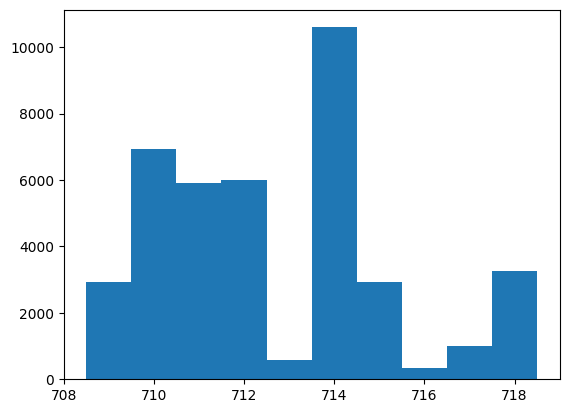

In [208]:
# Dam의 경우 714가 가장 많고 넓은 범위로 변동
sumx=df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Dam"]+df["HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Dam"]
plt.hist(sumx)

(array([8.6000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        4.0419e+04, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([ 614.8 ,  689.56,  764.32,  839.08,  913.84,  988.6 , 1063.36,
        1138.12, 1212.88, 1287.64, 1362.4 ]),
 <BarContainer object of 10 artists>)

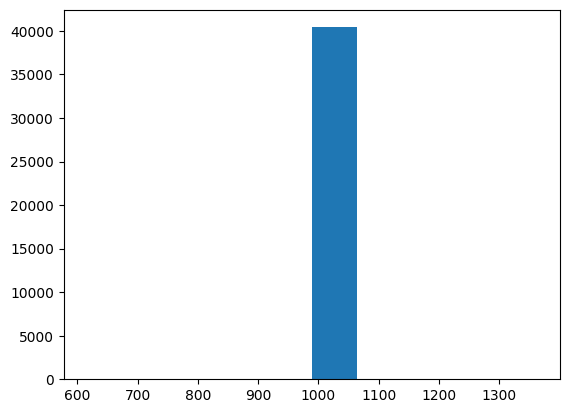

In [209]:
# Fill1의 경우 더한 값이 거의 하나의 값으로 나타남을 확인
sumx=df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1"]+df["HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1"]
plt.hist(sumx)

In [210]:
sumx.unique()

array([ 995.4,  994. ,  993.7,  994.7,  615.7,  994.4,  994.2,  994.9,
        995.2,  614.8,  994.6, 1362.4,  995.6,  996.2,  996.4,  995.9,
        995.5])

(array([25026.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
          896., 14584.]),
 array([991.5 , 992.25, 993.  , 993.75, 994.5 , 995.25, 996.  , 996.75,
        997.5 , 998.25, 999.  ]),
 <BarContainer object of 10 artists>)

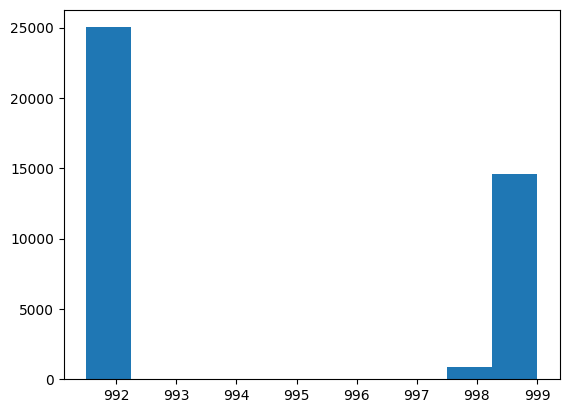

In [211]:
# Fill2의 경우 더한 값이 2개의 피크로 나타남을 확인
sumx=df["HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill2"]+df["HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill2"]
plt.hist(sumx)

방출 속력과 시간을 통해 부피 계산
v는 속력, t는 방출시간, V는 부피, A는 head의 단면적
$$
v=\frac{\Delta x}{\Delta t}\\
V=A\times \Delta x,\quad \Delta x=v\Delta t\\
V=A\times vt
$$

## 2가지로 시각화
1. x축을 v*t로 y축을 V로 하여 기울기가 A가 되도록 plot
2. x축을 index(row)로 y축을 A(V/vt)로 구하여 서로 다른 단면적이 얼마나 있는지 확인

## 결과
1. 기울기를 찾아(fitting) 단면적을 확인
2. target 또는 Equipment에 따라 다르게 나타날 것으로 예상했지만 무관함을 확인

In [212]:
# 기울기 계산 함수
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def fitting_1d(x,a,b):
    return a*x+b


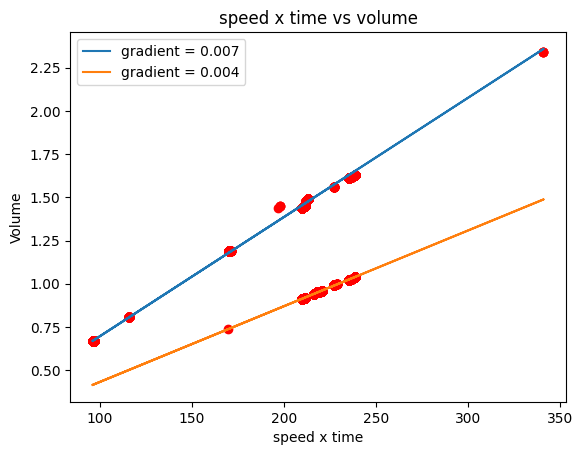

In [213]:
speed = df["DISCHARGED SPEED OF RESIN Collect Result_Dam"]

x = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam"]*speed
y = df["Dispense Volume(Stage1) Collect Result_Dam"]


threshold_grad = 0.005
y_ref= fitting_1d(x,threshold_grad,0)

# 데이터 구분
above_threshold = y > y_ref
below_threshold = y <= y_ref

# 구분된 데이터
x_above = x[above_threshold]
y_above = y[above_threshold]

x_below = x[below_threshold]
y_below = y[below_threshold]

color = df['target']
plt.title("speed x time vs volume")

plt.plot(x,y,'ro')
popt, pcov = curve_fit(fitting_1d, x_above, y_above)
plt.plot(x,fitting_1d(x,*popt),label=f'gradient = {popt[0]:.3f}')

popt, pcov = curve_fit(fitting_1d, x_below, y_below)
plt.plot(x,fitting_1d(x,*popt),label=f'gradient = {popt[0]:.3f}')


plt.xlabel("speed x time")
plt.ylabel("Volume")
plt.legend(loc='best')

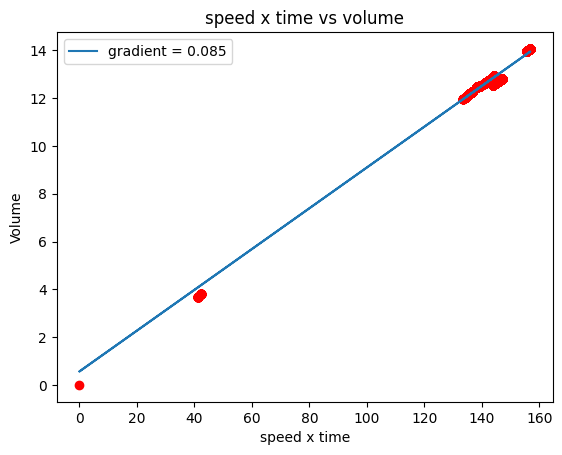

In [214]:
speed = df["DISCHARGED SPEED OF RESIN Collect Result_Fill1"]

x = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1"]*speed
y = df["Dispense Volume(Stage1) Collect Result_Fill1"]


threshold_grad = 0.0855
y_ref= fitting_1d(x,threshold_grad,0)

# 데이터 구분
above_threshold = y > y_ref
below_threshold = y <= y_ref

# 구분된 데이터
x_above = x[above_threshold]
y_above = y[above_threshold]

x_below = x[below_threshold]
y_below = y[below_threshold]

color = df['target']
plt.title("speed x time vs volume")

plt.plot(x,y,'ro')
popt, pcov = curve_fit(fitting_1d, x_above, y_above)
plt.plot(x,fitting_1d(x,*popt),label=f'gradient = {popt[0]:.3f}')

#opt, pcov = curve_fit(fitting_1d, x_below, y_below)
#plt.plot(x,fitting_1d(x,*popt),label=f'gradient = {popt[0]:.3f}')


plt.xlabel("speed x time")
plt.ylabel("Volume")
plt.legend(loc='best')

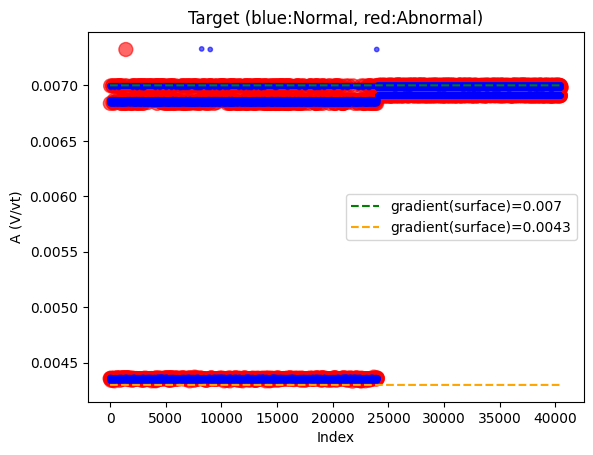

In [215]:
# 색상 및 크기 맵핑 설정
color_map = {'Normal': 'blue', 'AbNormal': 'red'}
size_map = {'Normal': 10, 'AbNormal': 100}  # 'Normal'은 작은 점, 'AbNormal'은 큰 점

# target 값을 색상과 크기로 매핑
df['color'] = df['target'].map(color_map)
df['size'] = df['target'].map(size_map)

# 필요한 값 계산
V = df["Dispense Volume(Stage1) Collect Result_Dam"]
v = df["DISCHARGED SPEED OF RESIN Collect Result_Dam"]
t = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam"]

# y축 값 계산 (A = V / (v * t))
df['A'] = V / (v * t)

# 데이터프레임을 크기에 따라 정렬 (큰 점 먼저)
df_sorted = df.sort_values(by='size', ascending=False)

# 플로팅
plt.title("Target (blue:Normal, red:Abnormal)")
plt.scatter(df_sorted.index, df_sorted['A'], c=df_sorted['color'], s=df_sorted['size'], alpha=0.6)

# 추가 라인 그리기 - 각 점에서의 일정한 y값을 생성하기 위해 x_index의 길이와 동일한 배열 생성
plt.plot(df.index, [0.007]*len(df), label="gradient(surface)=0.007", linestyle='--', color='green')
plt.plot(df.index, [0.0043]*len(df), label="gradient(surface)=0.0043", linestyle='--', color='orange')

plt.xlabel("Index")
plt.ylabel("A (V/vt)")
plt.legend(loc='best')
plt.show()


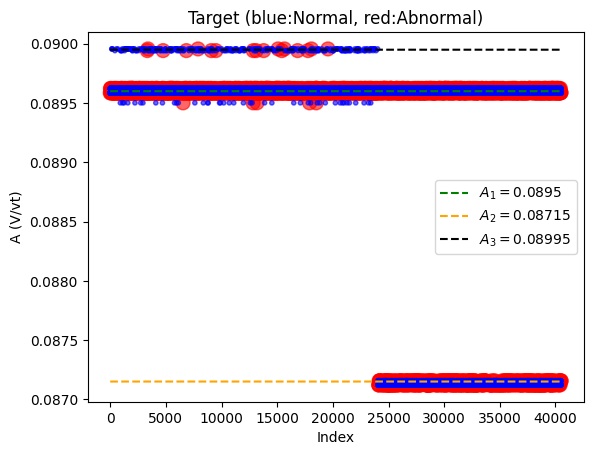

In [216]:

# 색상 및 크기 맵핑 설정
color_map = {'Normal': 'blue', 'AbNormal': 'red'}
size_map = {'Normal': 10, 'AbNormal': 100}  # 'Normal'은 작은 점, 'AbNormal'은 큰 점

# target 값을 색상과 크기로 매핑
df['color'] = df['target'].map(color_map)
df['size'] = df['target'].map(size_map)

# 필요한 값 계산
V = df["Dispense Volume(Stage1) Collect Result_Fill1"]
v = df["DISCHARGED SPEED OF RESIN Collect Result_Fill1"]
t = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1"]

# y축 값 계산 (A = V / (v * t))
df['A'] = V / (v * t)

# 데이터프레임을 크기에 따라 정렬 (큰 점 먼저)
df_sorted = df.sort_values(by='size', ascending=False)

# 플로팅
plt.title("Target (blue:Normal, red:Abnormal)")
plt.scatter(df_sorted.index, df_sorted['A'], c=df_sorted['color'], s=df_sorted['size'], alpha=0.6)

# 추가 라인 그리기 - 각 점에서의 일정한 y값을 생성하기 위해 x_index의 길이와 동일한 배열 생성
plt.plot(df.index, [0.0896]*len(df), label="$A_1=0.0895$", linestyle='--', color='green')
plt.plot(df.index, [0.08715]*len(df), label="$A_2=0.08715$", linestyle='--', color='orange')
plt.plot(df.index, [0.08995]*len(df), label="$A_3=0.08995$", linestyle='--', color='black')
plt.xlabel("Index")
plt.ylabel("A (V/vt)")
plt.legend(loc='best')
plt.show()


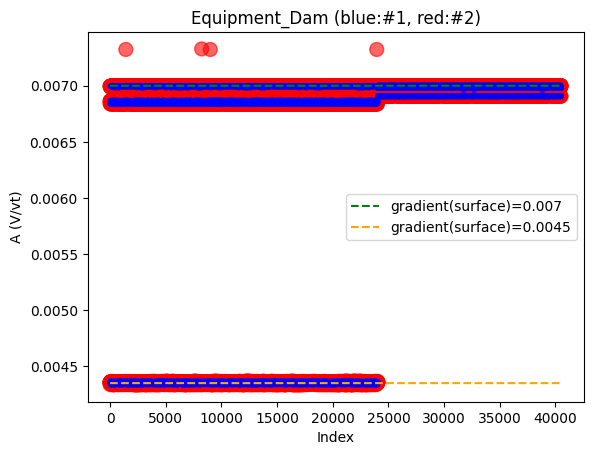

In [217]:
# 색상 및 크기 맵핑 설정
color_map = {'Dam dispenser #1': 'blue', 'Dam dispenser #2': 'red'}
size_map = {'Dam dispenser #1': 10, 'Dam dispenser #2': 100}  # '#1'은 작은 점, '#2'은 큰 점

# target 값을 색상과 크기로 매핑
df['color'] = df['Equipment_Dam'].map(color_map)
df['size'] = df['Equipment_Dam'].map(size_map)

# 필요한 값 계산
V = df["Dispense Volume(Stage1) Collect Result_Dam"]
v = df["DISCHARGED SPEED OF RESIN Collect Result_Dam"]
t = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam"]

# y축 값 계산 (A = V / (v * t))
df['A'] = V / (v * t)

# 데이터프레임을 크기에 따라 정렬 (큰 점 먼저)
df_sorted = df.sort_values(by='size', ascending=False)

# 플로팅
plt.title("Equipment_Dam (blue:#1, red:#2)")
plt.scatter(df_sorted.index, df_sorted['A'], c=df_sorted['color'], s=df_sorted['size'], alpha=0.6)

# 추가 라인 그리기 - 각 점에서의 일정한 y값을 생성하기 위해 x_index의 길이와 동일한 배열 생성
plt.plot(df.index, [0.007]*len(df), label="gradient(surface)=0.007", linestyle='--', color='green')
plt.plot(df.index, [0.00435]*len(df), label="gradient(surface)=0.0045", linestyle='--', color='orange')

plt.xlabel("Index")
plt.ylabel("A (V/vt)")
plt.legend(loc='best')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


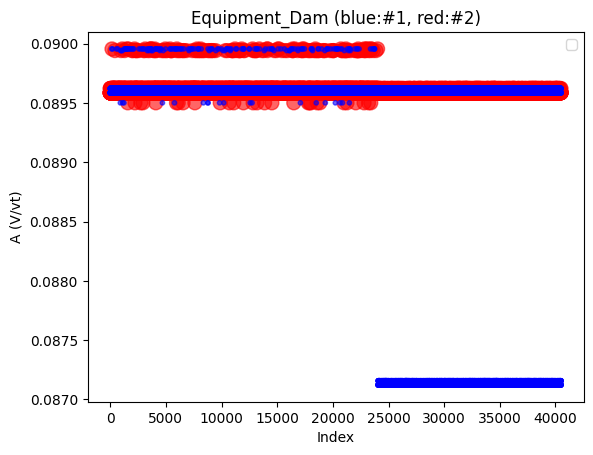

In [218]:
# 색상 및 크기 맵핑 설정
color_map = {'Fill1 dispenser #1': 'blue', 'Fill1 dispenser #2': 'red'}
size_map = {'Fill1 dispenser #1': 10, 'Fill1 dispenser #2': 100}  # '#1'은 작은 점, '#2'은 큰 점

# target 값을 색상과 크기로 매핑
df['color'] = df['Equipment_Fill1'].map(color_map)
df['size'] = df['Equipment_Fill1'].map(size_map)

# 필요한 값 계산
V = df["Dispense Volume(Stage1) Collect Result_Fill1"]
v = df["DISCHARGED SPEED OF RESIN Collect Result_Fill1"]
t = df["DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1"]

# y축 값 계산 (A = V / (v * t))
df['A'] = V / (v * t)

# 데이터프레임을 크기에 따라 정렬 (큰 점 먼저)
df_sorted = df.sort_values(by='size', ascending=False)

# 플로팅
plt.title("Equipment_Dam (blue:#1, red:#2)")
plt.scatter(df_sorted.index, df_sorted['A'], c=df_sorted['color'], s=df_sorted['size'], alpha=0.6)

# 추가 라인 그리기 - 각 점에서의 일정한 y값을 생성하기 위해 x_index의 길이와 동일한 배열 생성

plt.xlabel("Index")
plt.ylabel("A (V/vt)")
plt.legend(loc='best')
plt.show()


# 상관 관계 equipment 111

In [219]:
# Load data
df = pd.read_csv(os.path.join(ROOT_DIR, "train_cleaned.csv"))

In [220]:
cond1 = (df['Equipment_Dam']=='Dam dispenser #1')
cond2 = (df['Equipment_Fill1']=='Fill1 dispenser #1')
cond3 = (df['Equipment_Fill2']=='Fill2 dispenser #1')
cond3 = (df['Equipment_Fill2']=='Fill2 dispenser #1')

df1 = df[cond1&cond2&cond3]
df1

Equipment_Dam Model.Suffix  CURE END POSITION X Collect Result_Dam  \
0      Dam dispenser #1  AJX75334505                                   240.0   
2      Dam dispenser #1  AJX75334501                                   240.0   
8      Dam dispenser #1  AJX75334502                                   240.0   
9      Dam dispenser #1  AJX75334501                                   240.0   
10     Dam dispenser #1  AJX75334501                                   240.0   
...                 ...          ...                                     ...   
40500  Dam dispenser #1  AJX75334501                                   240.0   
40501  Dam dispenser #1  AJX75334501                                   240.0   
40502  Dam dispenser #1  AJX75334501                                   240.0   
40503  Dam dispenser #1  AJX75334501                                   240.0   
40505  Dam dispenser #1  AJX75334501                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
2                                         2.5   
8                                         2.5   
9                                         2.5   
10                                        2.5   
...                                       ...   
40500                                     2.5   
40501                                     2.5   
40502                                     2.5   
40503                                     2.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  CURE SPEED Collect Result_Dam  \
0                                         -90                            100   
2                                         -90                             70   
8                                         -90                             70   
9                                         -90                             70   
10                                        -90                             70   
...                                       ...                            ...   
40500                                     -90                             70   
40501                                     -90                             70   
40502                                     -90                             70   
40503                                     -90                             70   
40505                                     -90                             70   

       CURE START POSITION X Collect Result_Dam  \
0                                          1030   
2                                          1030   
8                                          1030   
9                                          1030   
10                                         1030   
...                                         ...   
40500                                      1030   
40501                                      1030   
40502                                      1030   
40503                                      1030   
40505                                      1030   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
2                                                16   
8                                                16   
9                                                16   
10                                               16   
...                                             ...   
40500                                            10   
40501                                            10   
40502                                            10   
40503                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
2                                                   13.2     
8                                      

In [221]:
# 'object' 타입 컬럼의 이름만 출력
print(df1.columns[df1.dtypes == 'object'])

Index(['Equipment_Dam', 'Model.Suffix', 'Chamber Temp. Judge Value_AutoClave',
       'Equipment_Fill1', 'Equipment_Fill2', 'target'],
      dtype='object')


In [222]:
# 수치형 데이터만 선택
df_num = df1.select_dtypes(exclude='object')

# target을 binary 형태로 저장 AbNormal:0 Normal:1
label_encoder = LabelEncoder()
df_num['target'] = label_encoder.fit_transform(df1['target'])
df_num

CURE END POSITION X Collect Result_Dam  \
0                                       240.0   
2                                       240.0   
8                                       240.0   
9                                       240.0   
10                                      240.0   
...                                       ...   
40500                                   240.0   
40501                                   240.0   
40502                                   240.0   
40503                                   240.0   
40505                                   240.0   

       CURE END POSITION Z Collect Result_Dam  \
0                                         2.5   
2                                         2.5   
8                                         2.5   
9                                         2.5   
10                                        2.5   
...                                       ...   
40500                                     2.5   
40501                                     2.5   
40502                                     2.5   
40503                                     2.5   
40505                                     2.5   

       CURE END POSITION Θ Collect Result_Dam  CURE SPEED Collect Result_Dam  \
0                                         -90                            100   
2                                         -90                             70   
8                                         -90                             70   
9                                         -90                             70   
10                                        -90                             70   
...                                       ...                            ...   
40500                                     -90                             70   
40501                                     -90                             70   
40502                                     -90                             70   
40503                                     -90                             70   
40505                                     -90                             70   

       CURE START POSITION X Collect Result_Dam  \
0                                          1030   
2                                          1030   
8                                          1030   
9                                          1030   
10                                         1030   
...                                         ...   
40500                                      1030   
40501                                      1030   
40502                                      1030   
40503                                      1030   
40505                                      1030   

       DISCHARGED SPEED OF RESIN Collect Result_Dam  \
0                                                16   
2                                                16   
8                                                16   
9                                                16   
10                                               16   
...                                             ...   
40500                                            10   
40501                                            10   
40502                                            10   
40503                                            10   
40505                                            10   

       DISCHARGED TIME OF RESIN(Stage1) Collect Result_Dam  \
0                                                   14.9     
2                                                   13.2     
8                                                   14.2     
9                                                   13.2     
10                                                  13.6     
...                                                  ...     
40500                                                9.6     
40501                                                9.7     
40502                               

In [223]:
# 매핑된 값 확인
print("\nLabelEncoder mapping:")
for i, class_label in enumerate(label_encoder.classes_):
    print(f"{class_label}: {i}")


LabelEncoder mapping:
AbNormal: 0
Normal: 1


In [224]:
# NaN이 발생하는 이유는 한 컬럼에 포함된 데이터의 분산이 0이기 때문에 corr구할때, NaN을 나타냄
# 따라서 0으로 변경
correlation_matrix = df_num.corr()
correlation_matrix = correlation_matrix.fillna(0)
print(correlation_matrix)

                                          CURE END POSITION X Collect Result_Dam  \
CURE END POSITION X Collect Result_Dam                                       0.0   
CURE END POSITION Z Collect Result_Dam                                       0.0   
CURE END POSITION Θ Collect Result_Dam                                       0.0   
CURE SPEED Collect Result_Dam                                                0.0   
CURE START POSITION X Collect Result_Dam                                     0.0   
...                                                                          ...   
Machine Tact time Collect Result_Fill2                                       0.0   
PalletID Collect Result_Fill2                                                0.0   
Production Qty Collect Result_Fill2                                          0.0   
Receip No Collect Result_Fill2                                               0.0   
target                                                                      

## 전체 data corr

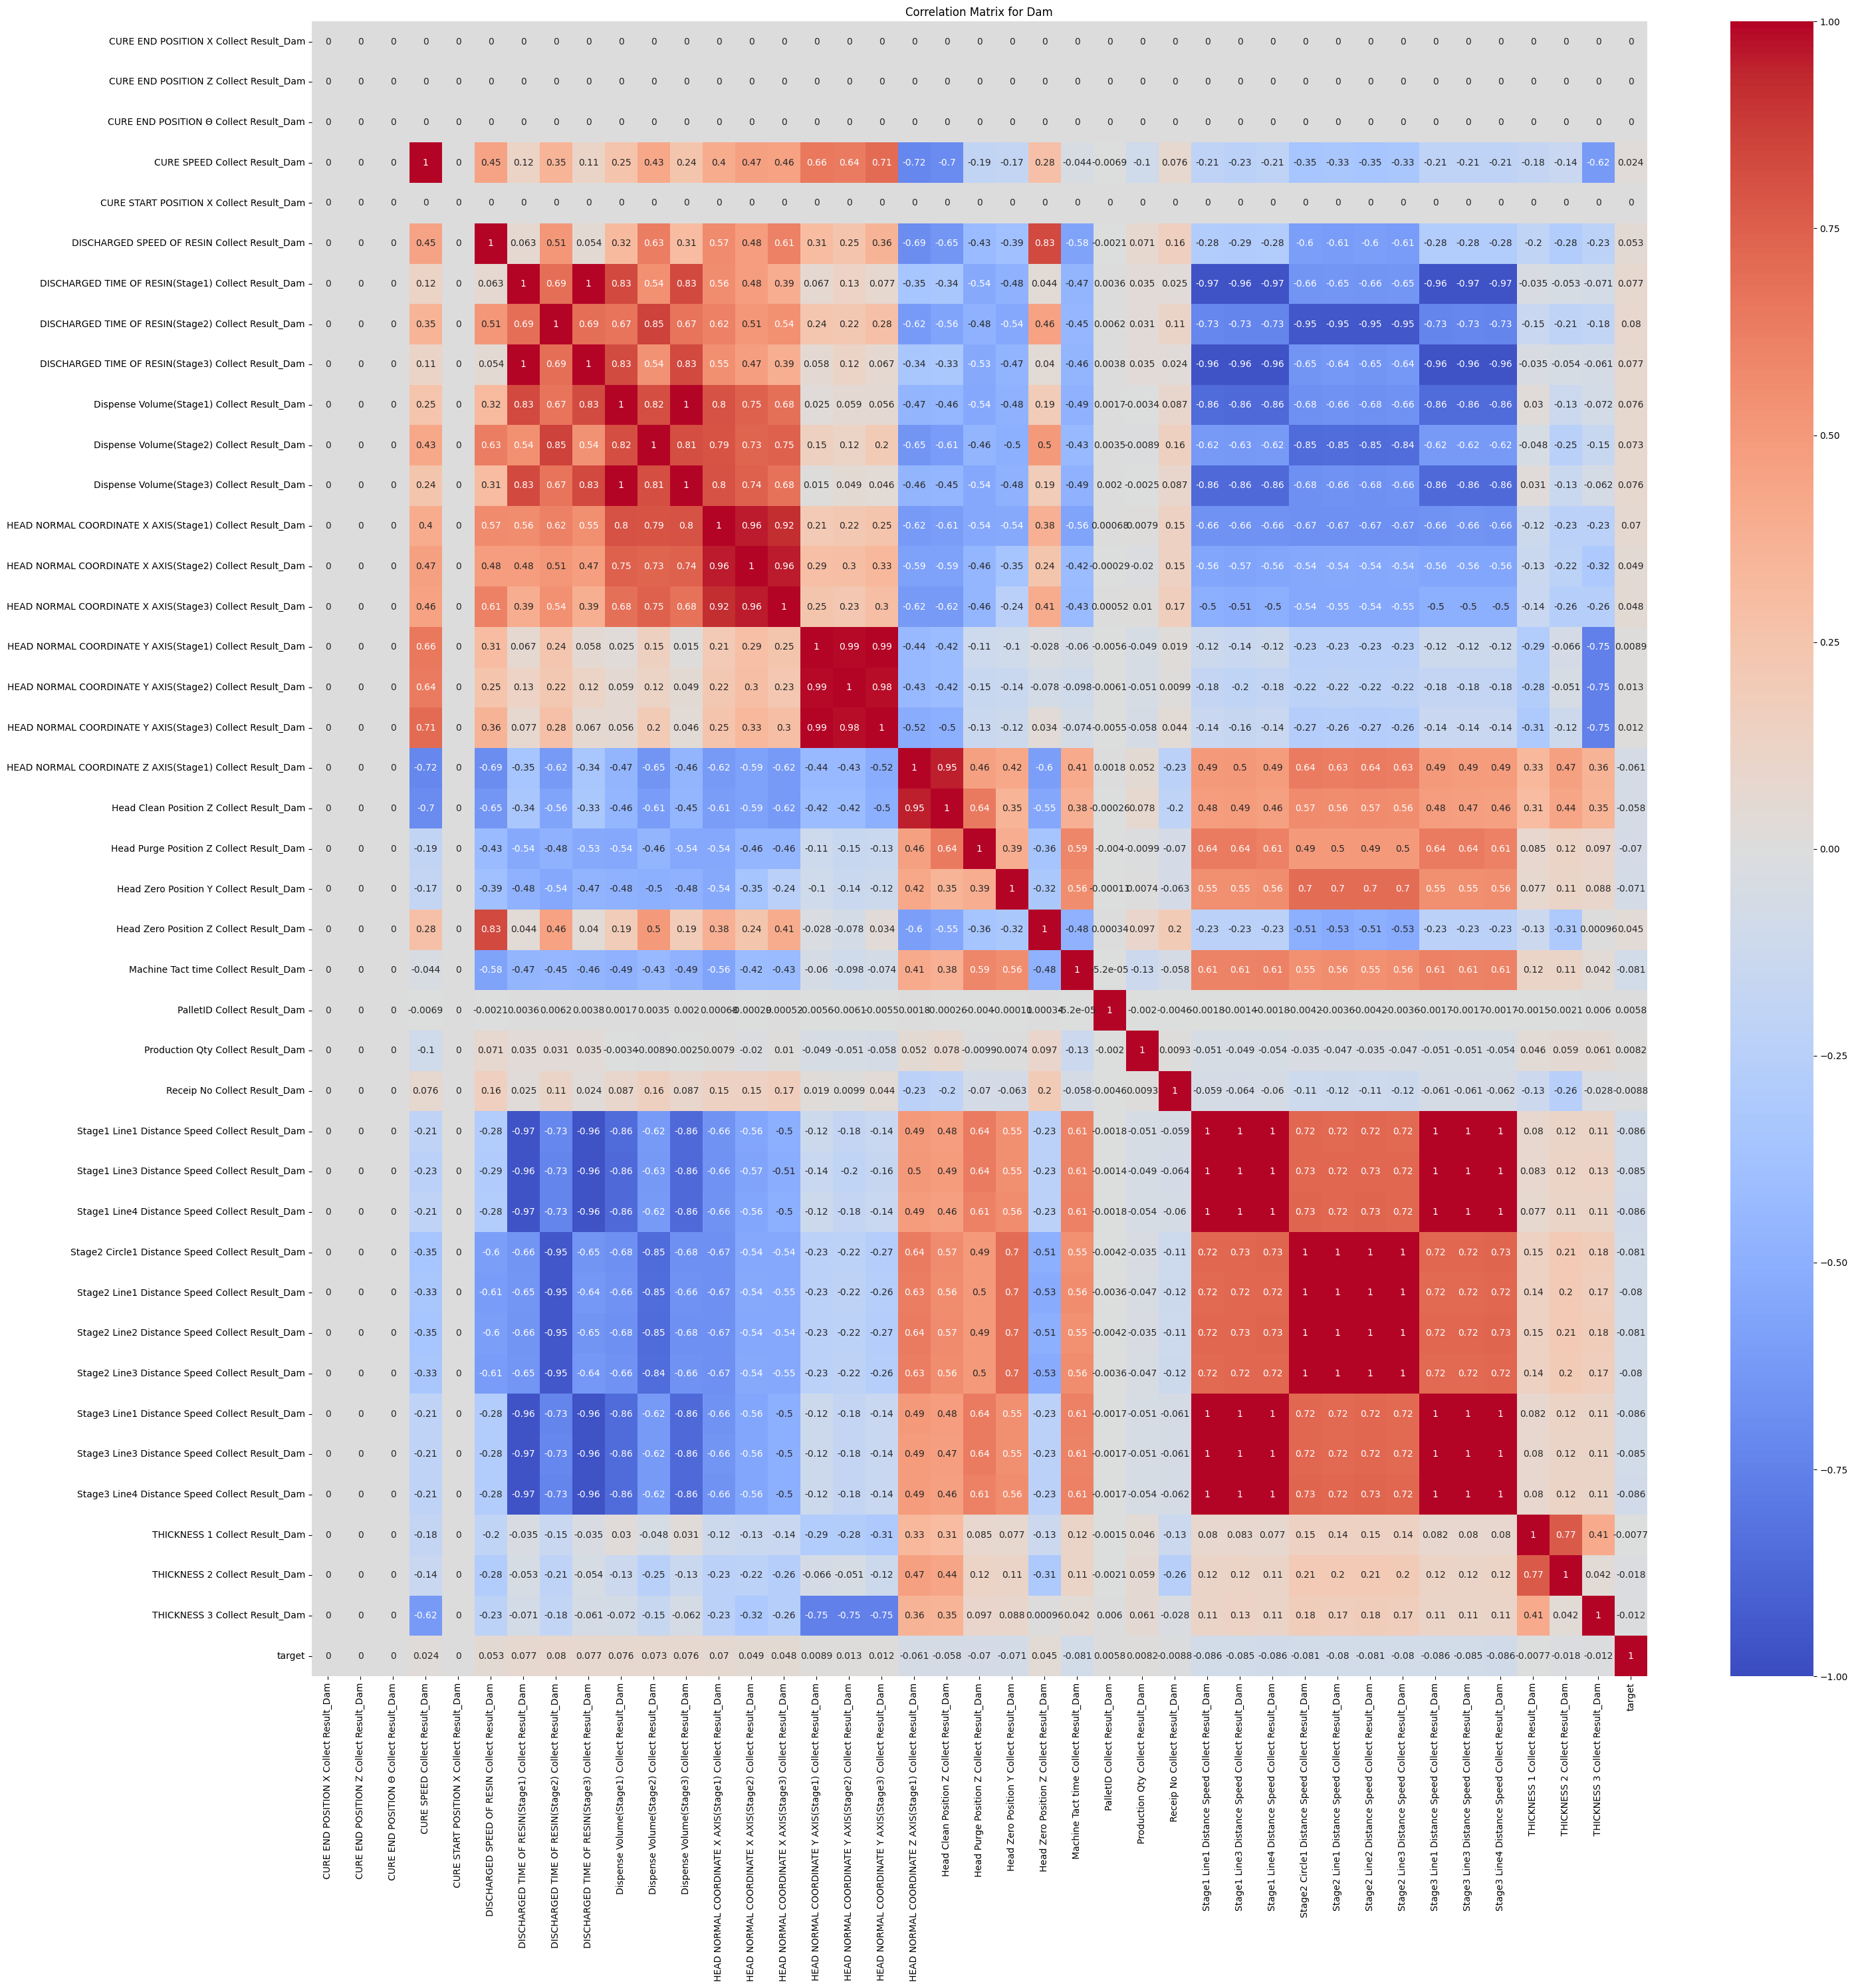

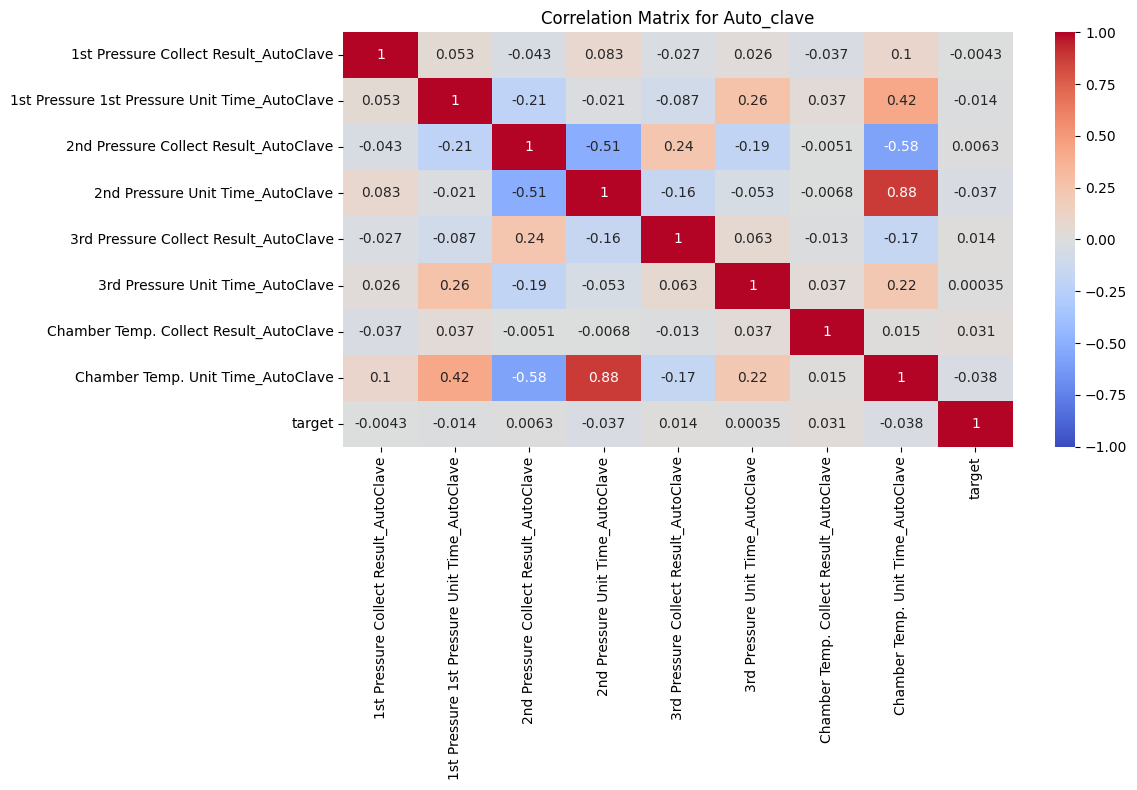

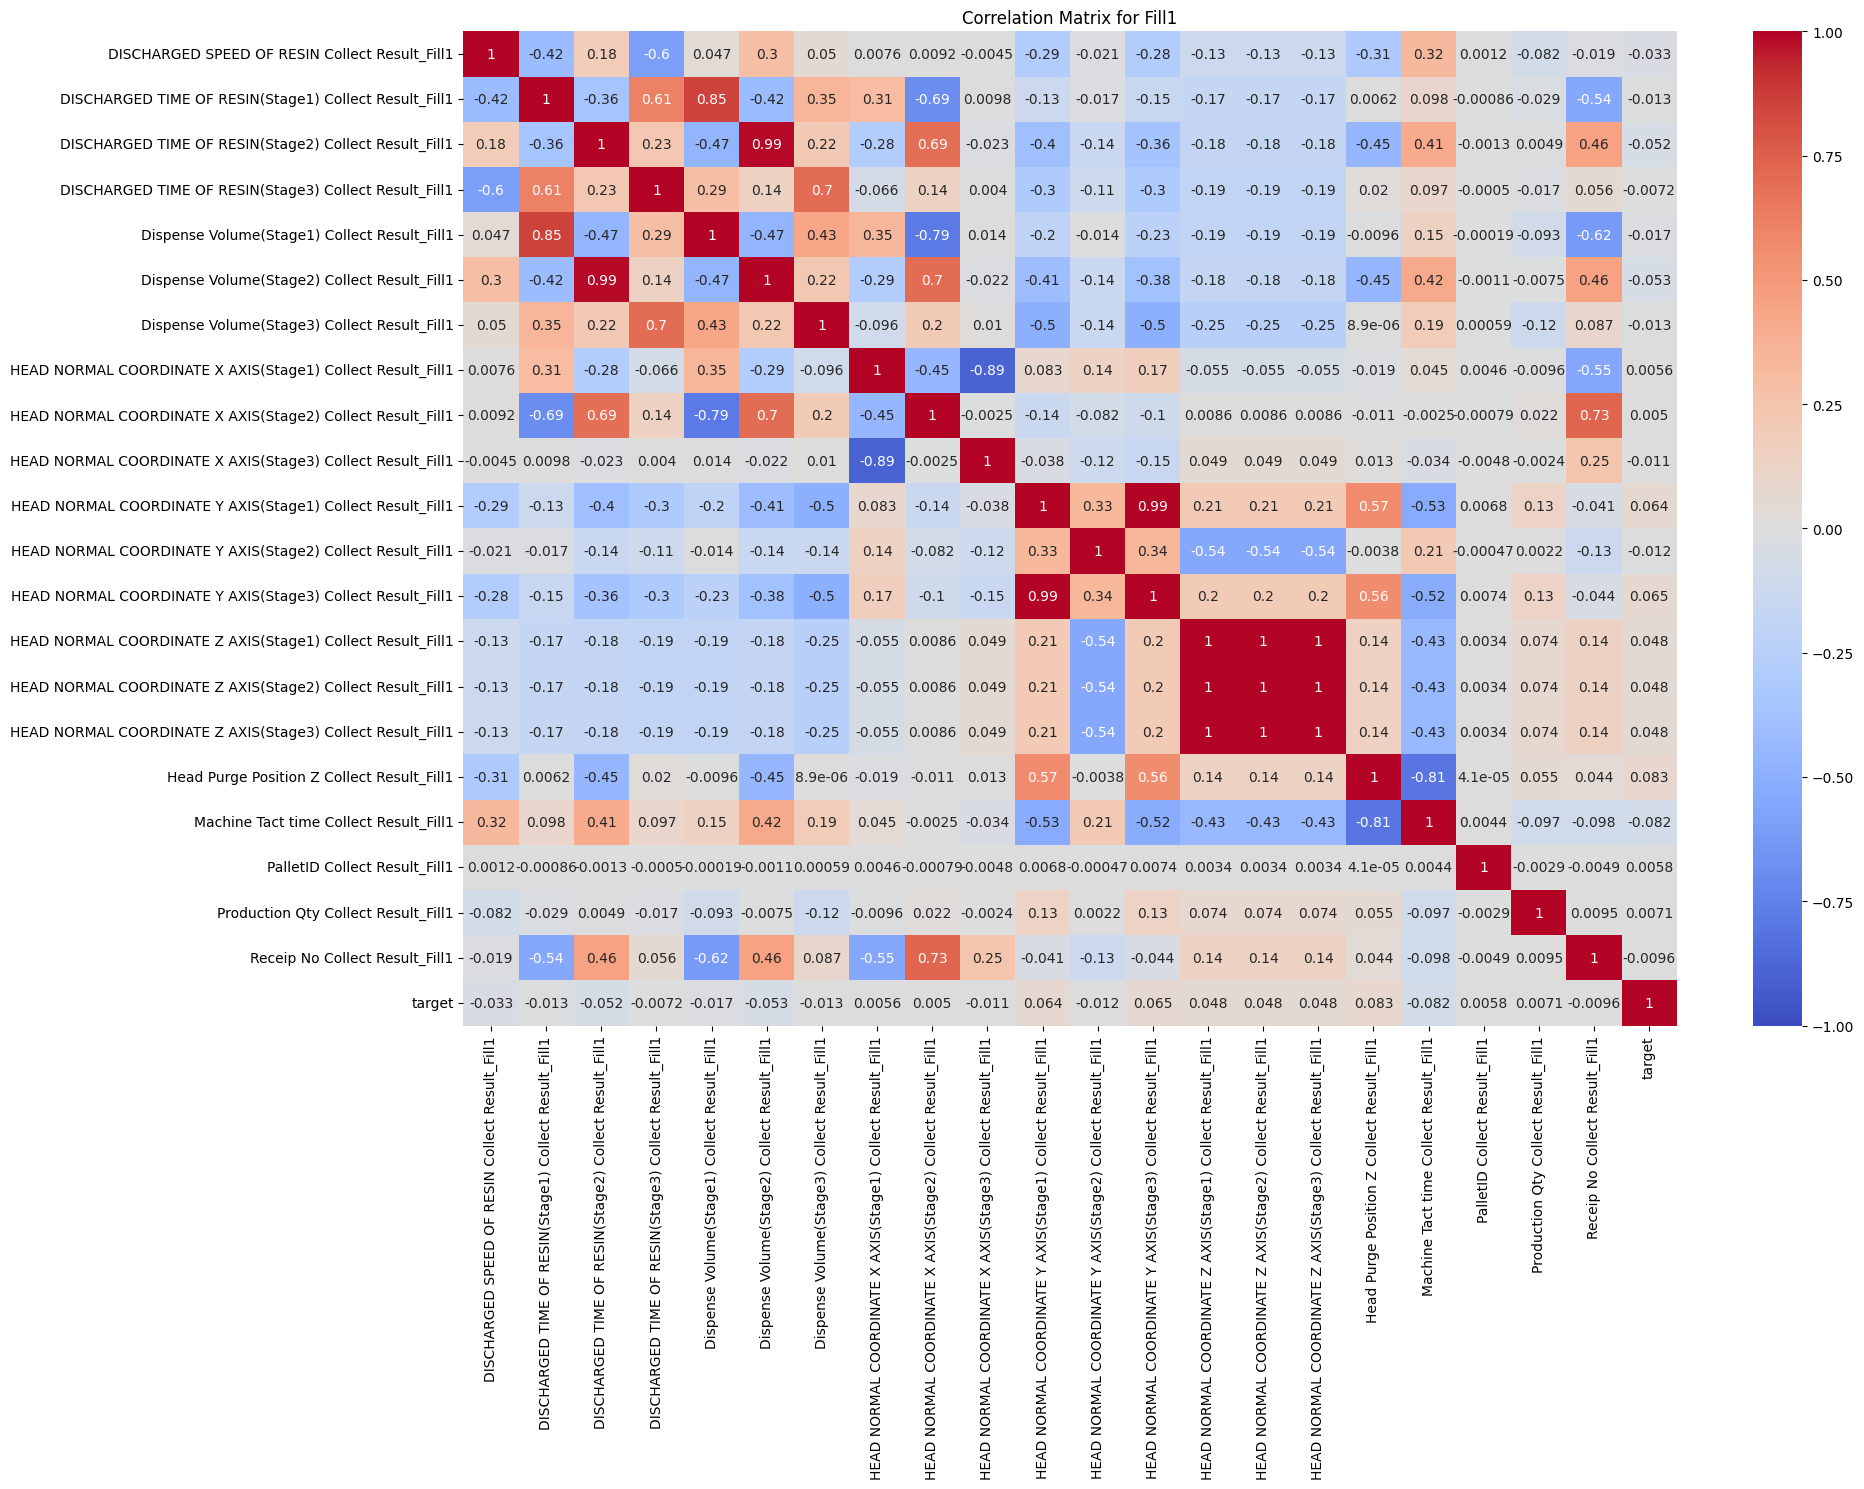

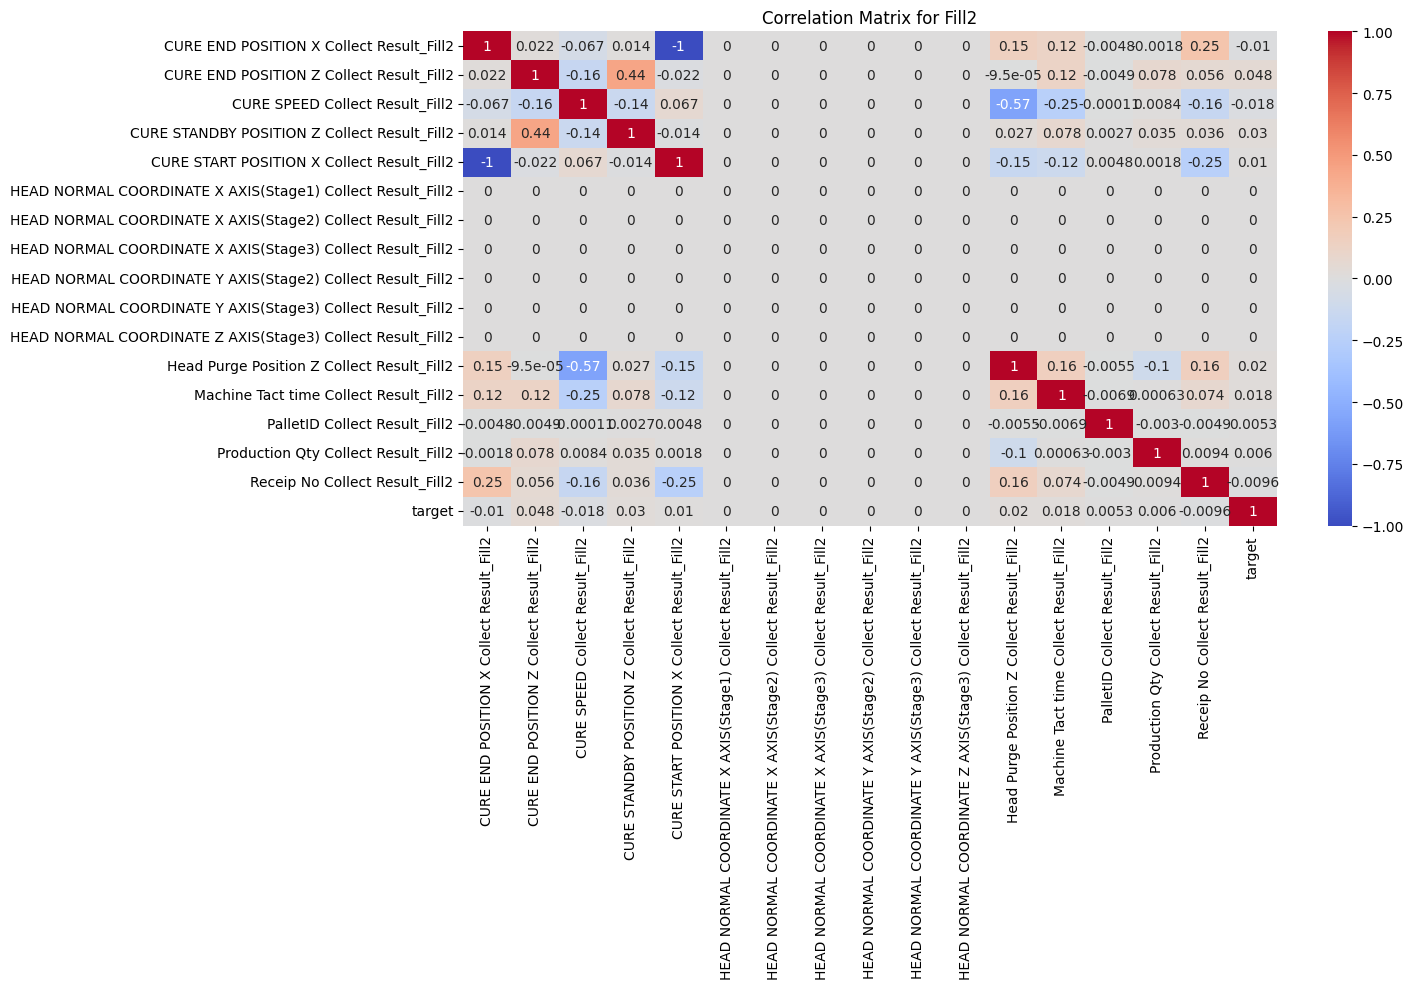

In [239]:
# 한 번에 plot하면 분석하기 어려워, 공정에 맞게 4개로 그룹지어 plot
# 그룹 정의
groups = {
    'Dam': df_num.filter(like='Dam').columns,
    'Auto_clave': df_num.filter(like='Auto').columns,
    'Fill1': df_num.filter(like='Fill1').columns,
    'Fill2': df_num.filter(like='Fill2').columns
}

# 상관 행렬 계산 및 시각화
figs=[(30, 30),(12,8),(20,15),(15,10)]


idx=0
for group_name, columns in groups.items():
    # 그룹에 해당하는 데이터 추출
    columns_with_target = list(columns) + ['target']
    
    # 'target' 열 추가된 데이터프레임 생성
    df_group = df_num[columns_with_target]
    
    # 상관 행렬 계산
    correlation_matrix = df_group.corr()
    correlation_matrix = correlation_matrix.fillna(0)
    
    # 상관 행렬 시각화
    plt.figure(figsize=figs[idx])
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Matrix for {group_name}')
    plt.tight_layout()
    plt.savefig(f'./plot/Correlation Matrix for {group_name}_total.png')
    plt.show()
    idx+=1

## Normal 데이터

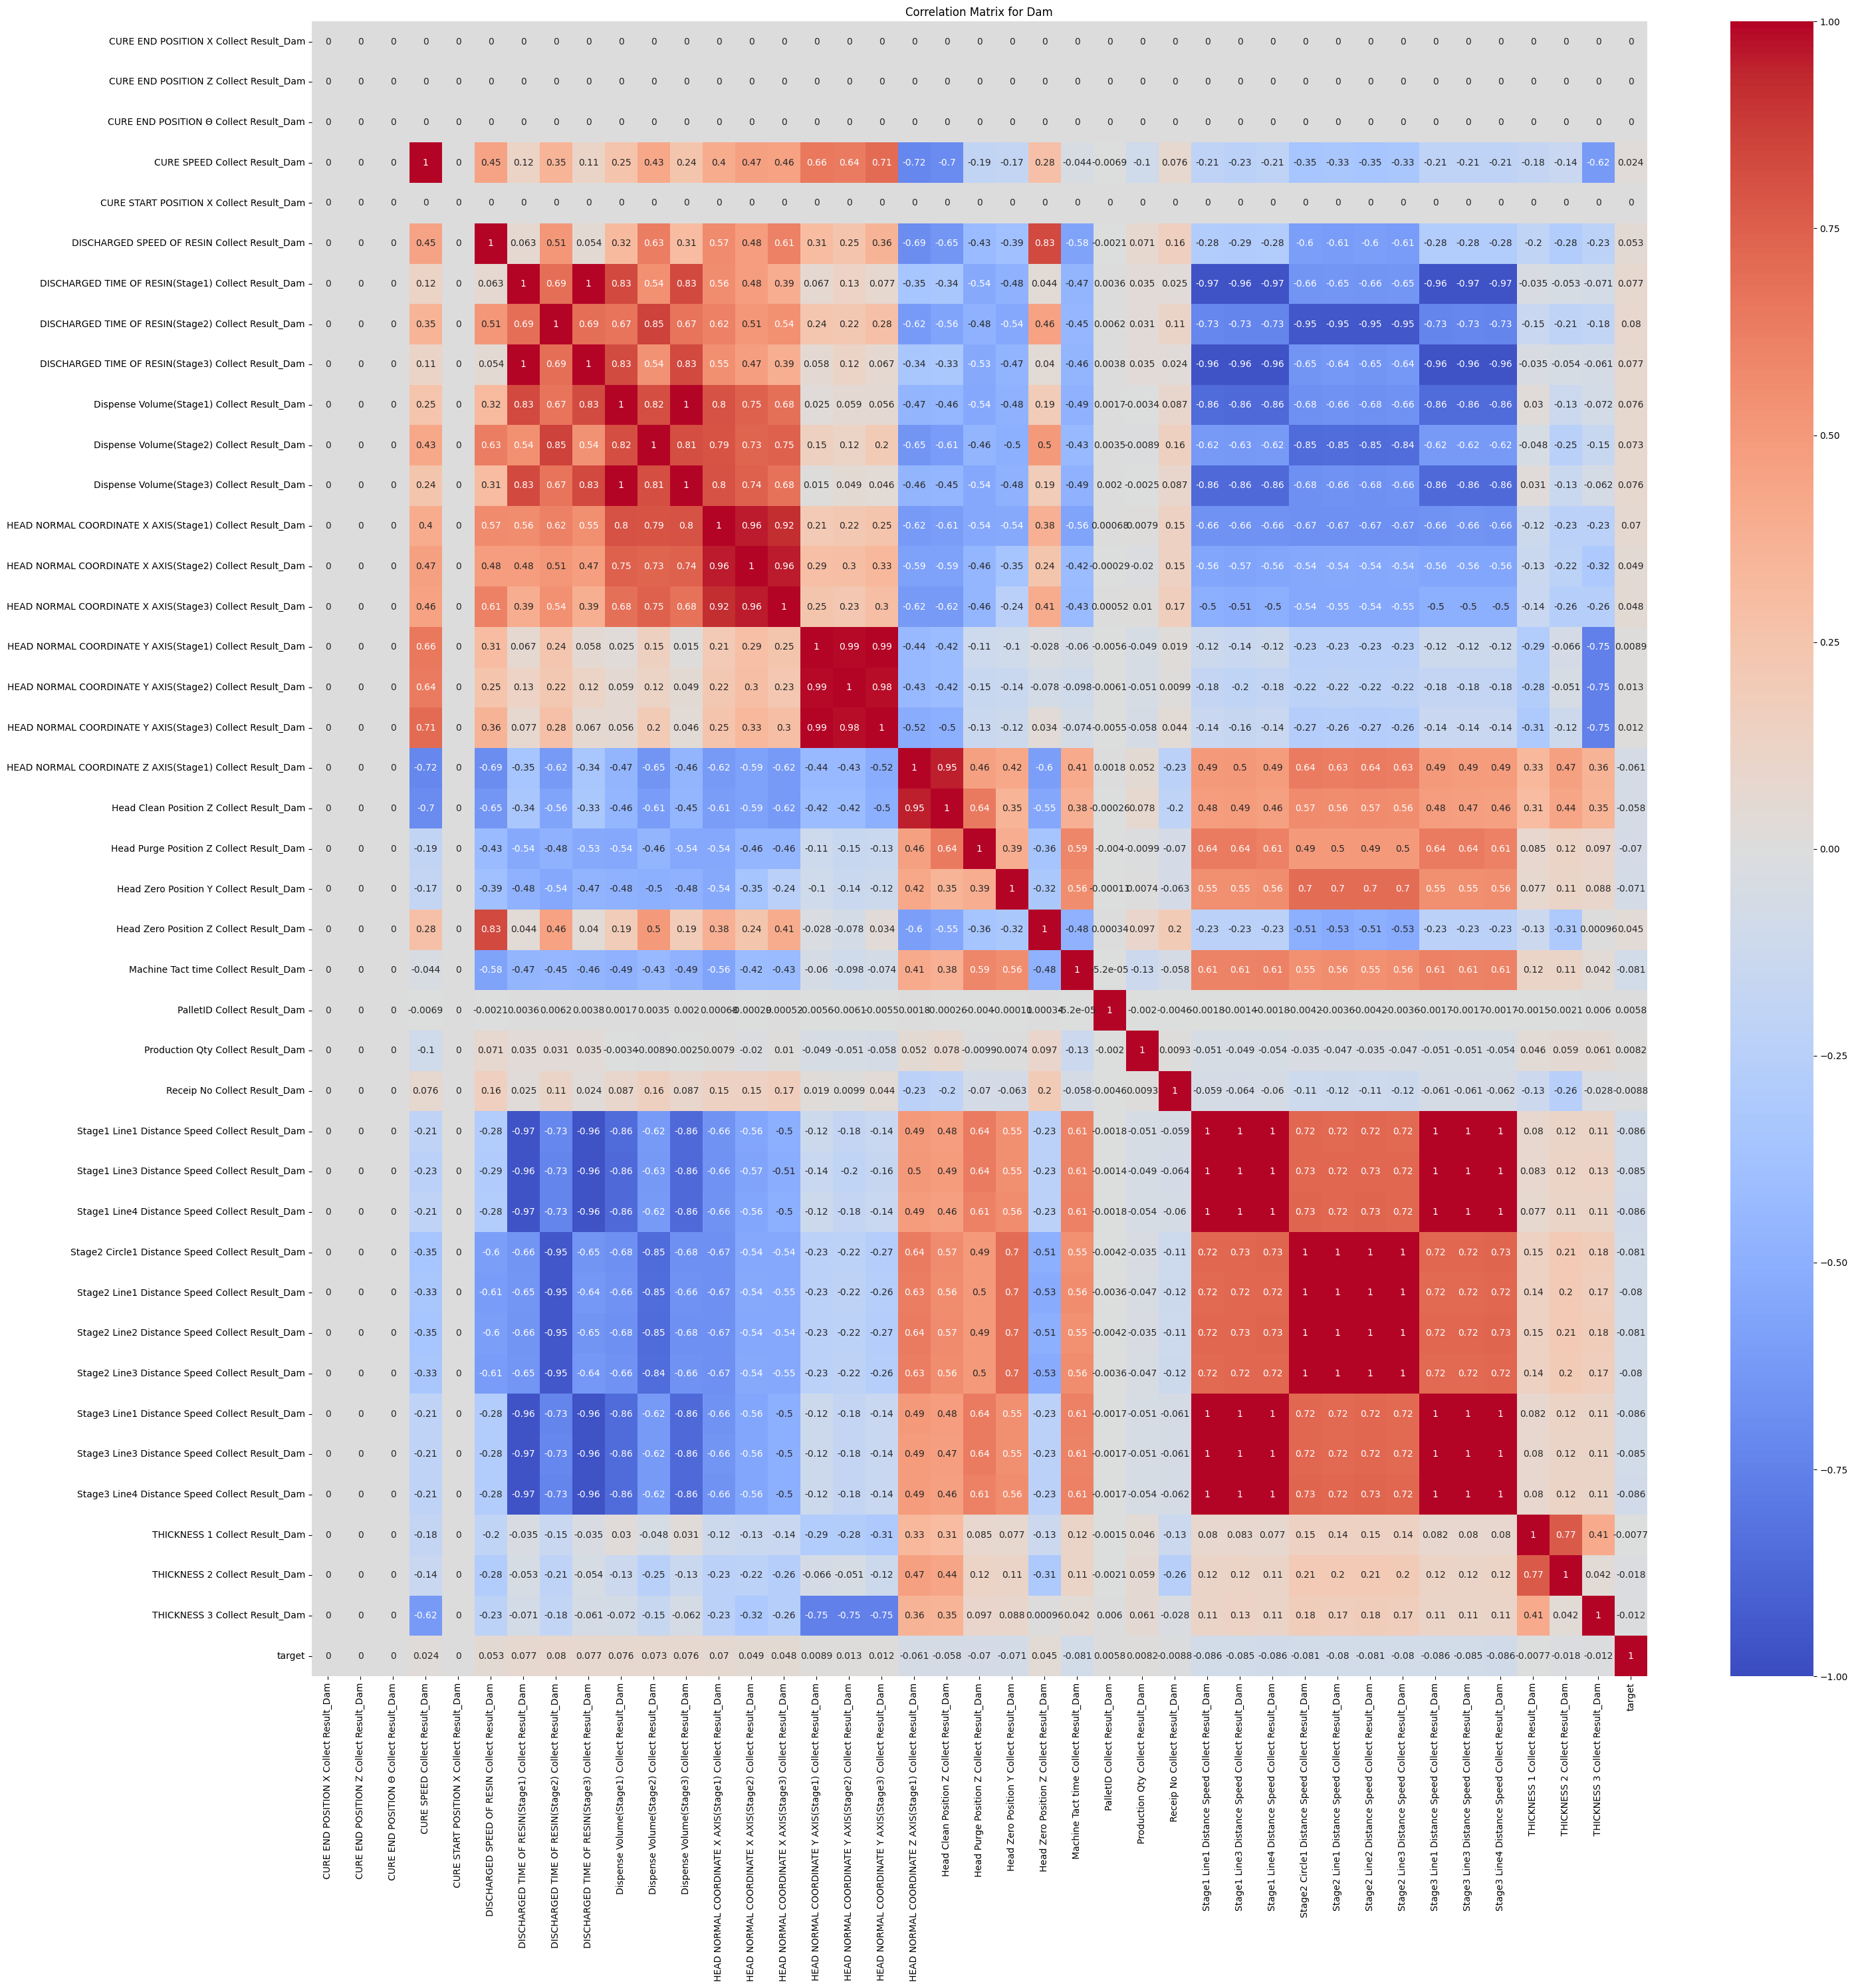

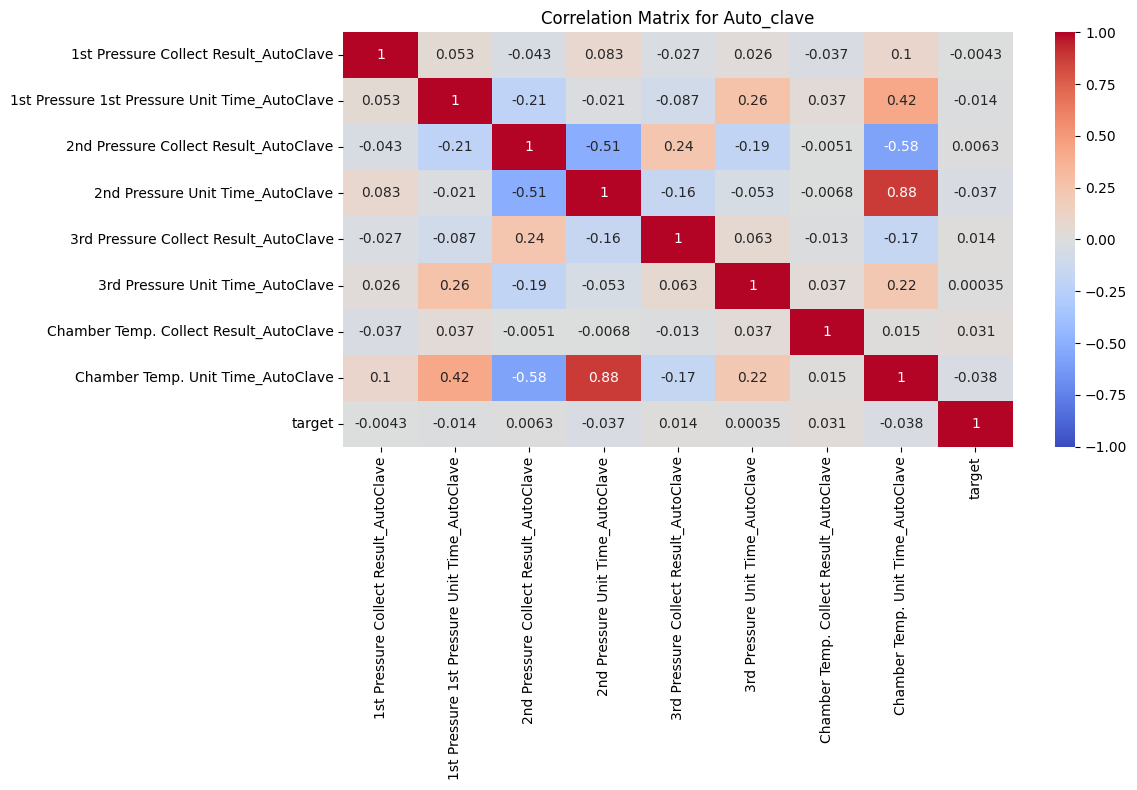

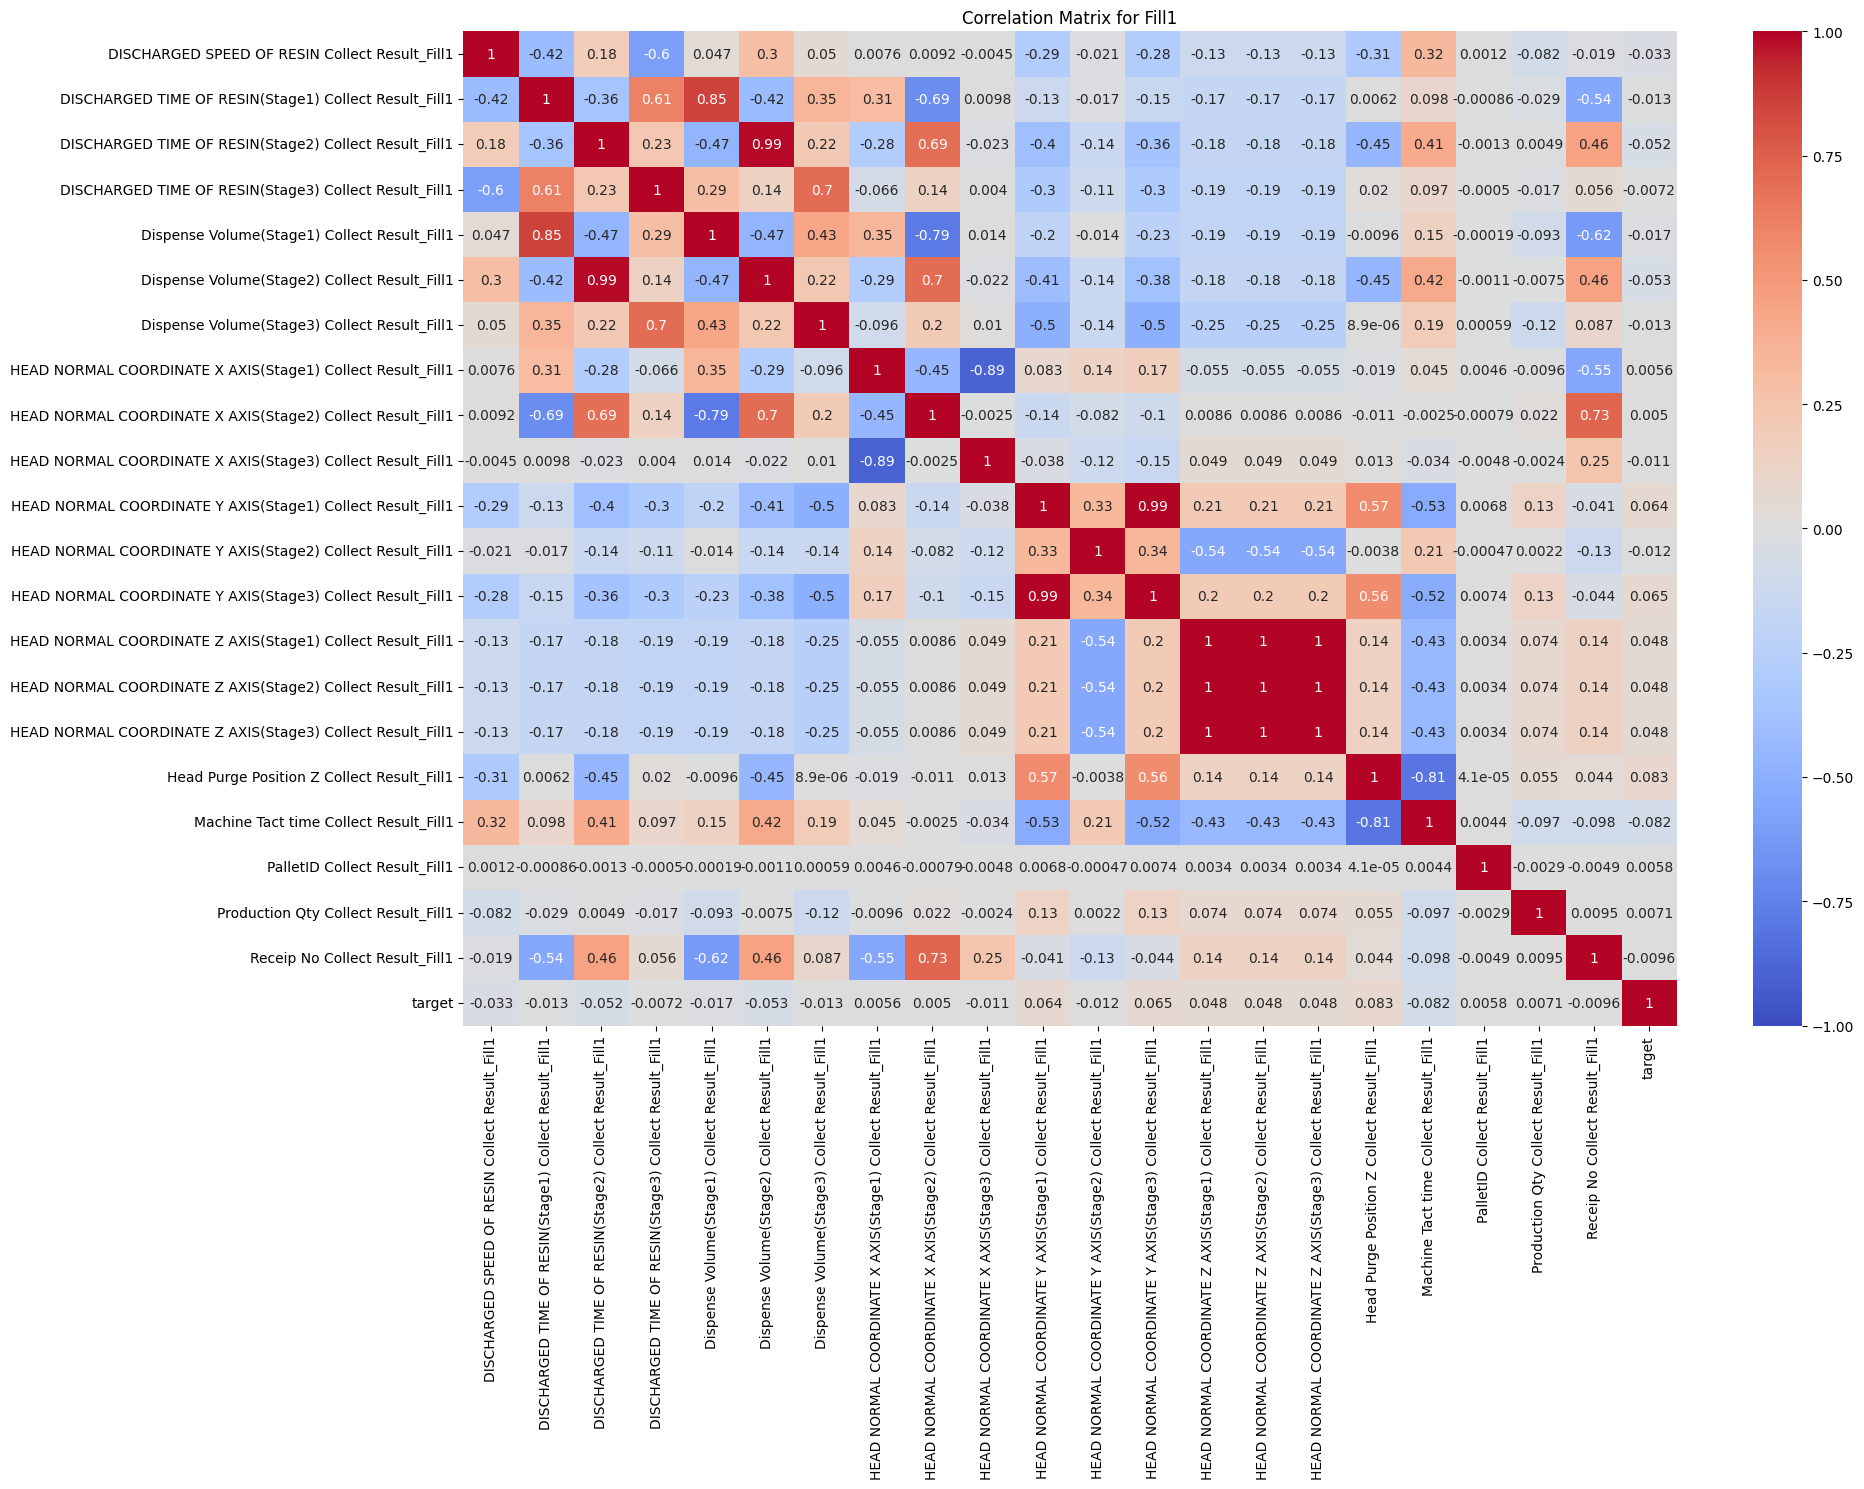

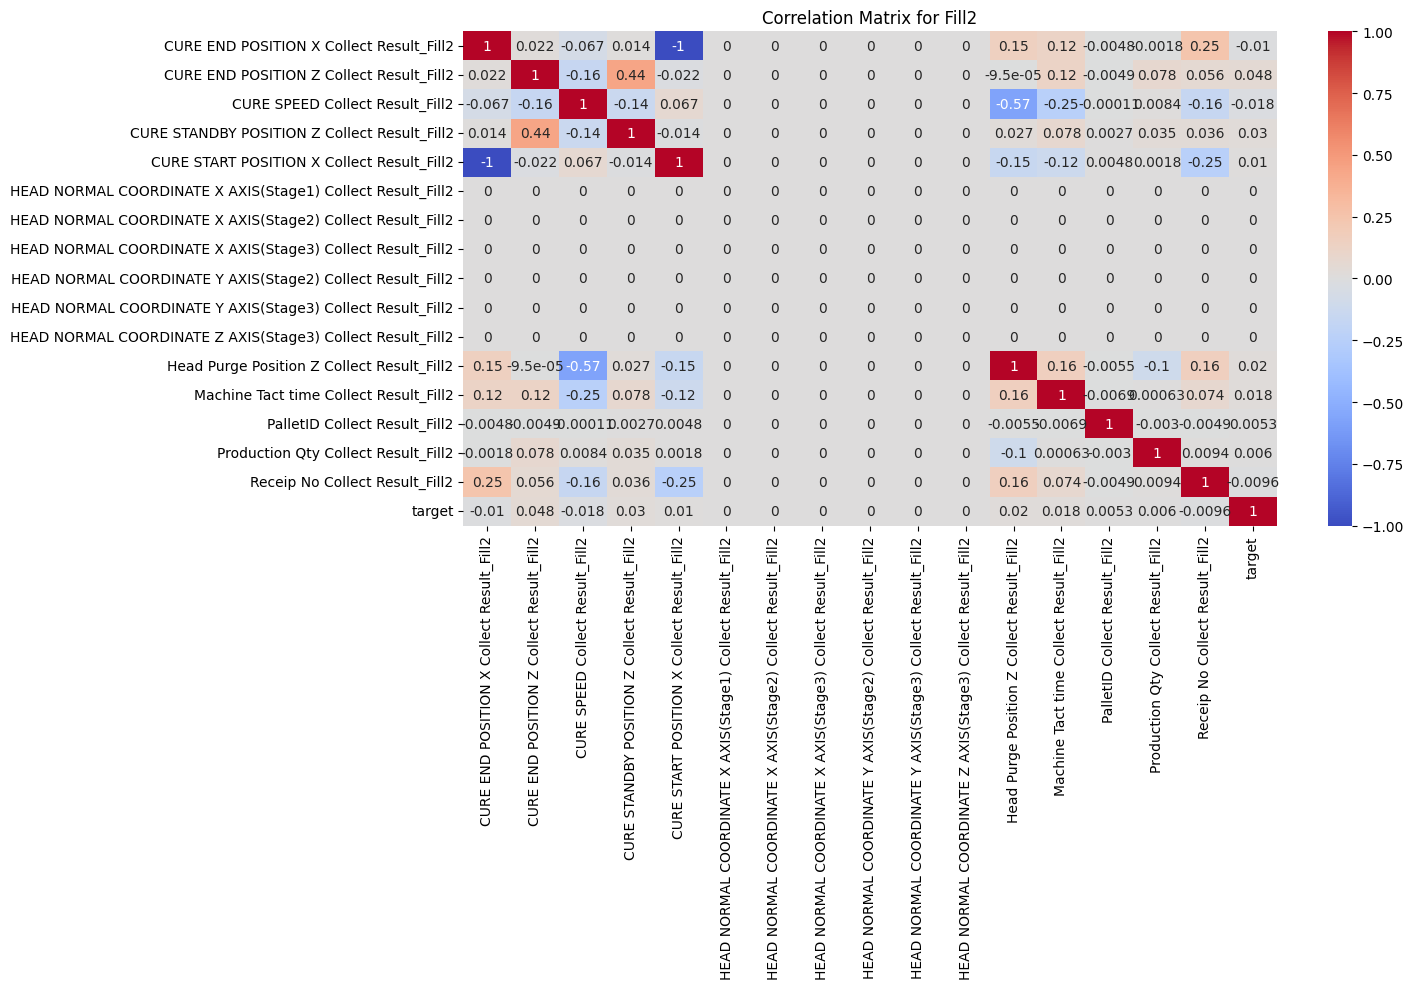

In [240]:
# Normal 데이터만 수집
df_normal = df_num[df_num['target']==1]

idx=0
for group_name, columns in groups.items():
    # 그룹에 해당하는 데이터 추출
    columns_with_target = list(columns) + ['target']
    # 'target' 열 추가된 데이터프레임 생성
    df_group = df_num[columns_with_target]
    
    # 상관 행렬 계산
    correlation_matrix = df_group.corr()
    correlation_matrix = correlation_matrix.fillna(0)
    # 상관 행렬 시각화
    plt.figure(figsize=figs[idx])
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Matrix for {group_name}')
    plt.tight_layout()
    plt.savefig(f'./plot/Correlation Matrix for {group_name}_Nomal.png')
    plt.show()
    idx+=1

## AbNormal 데이터

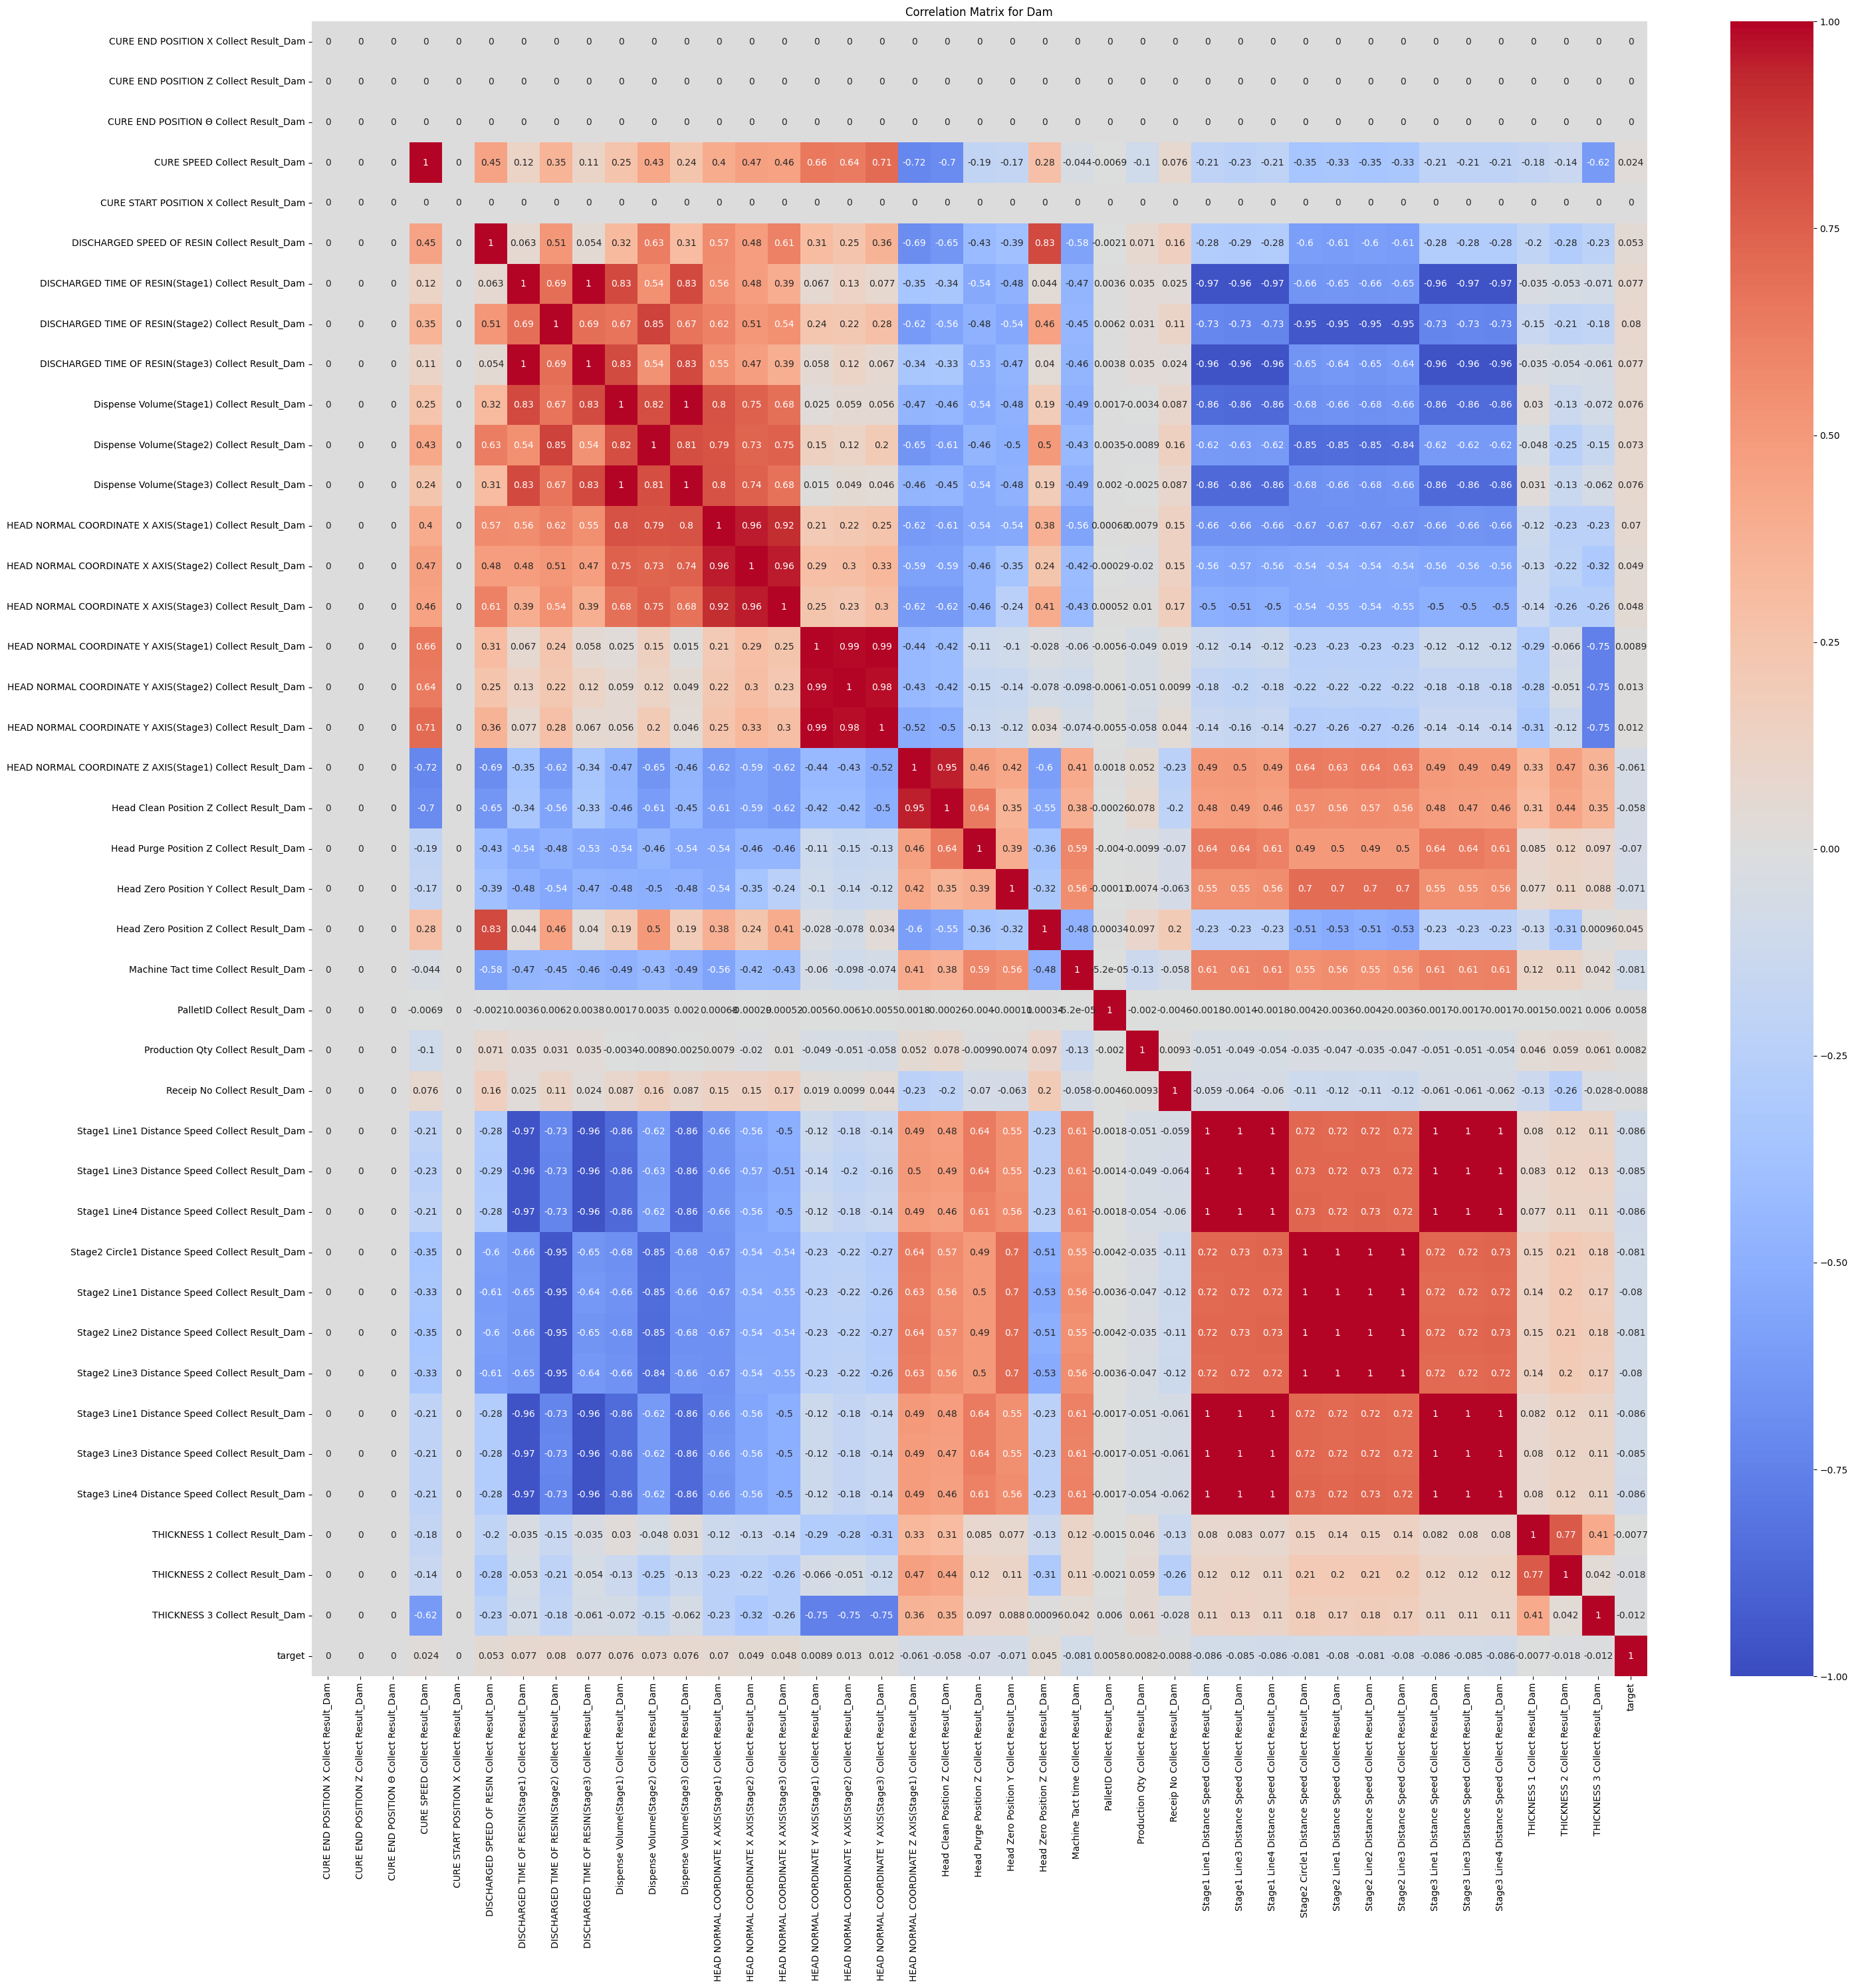

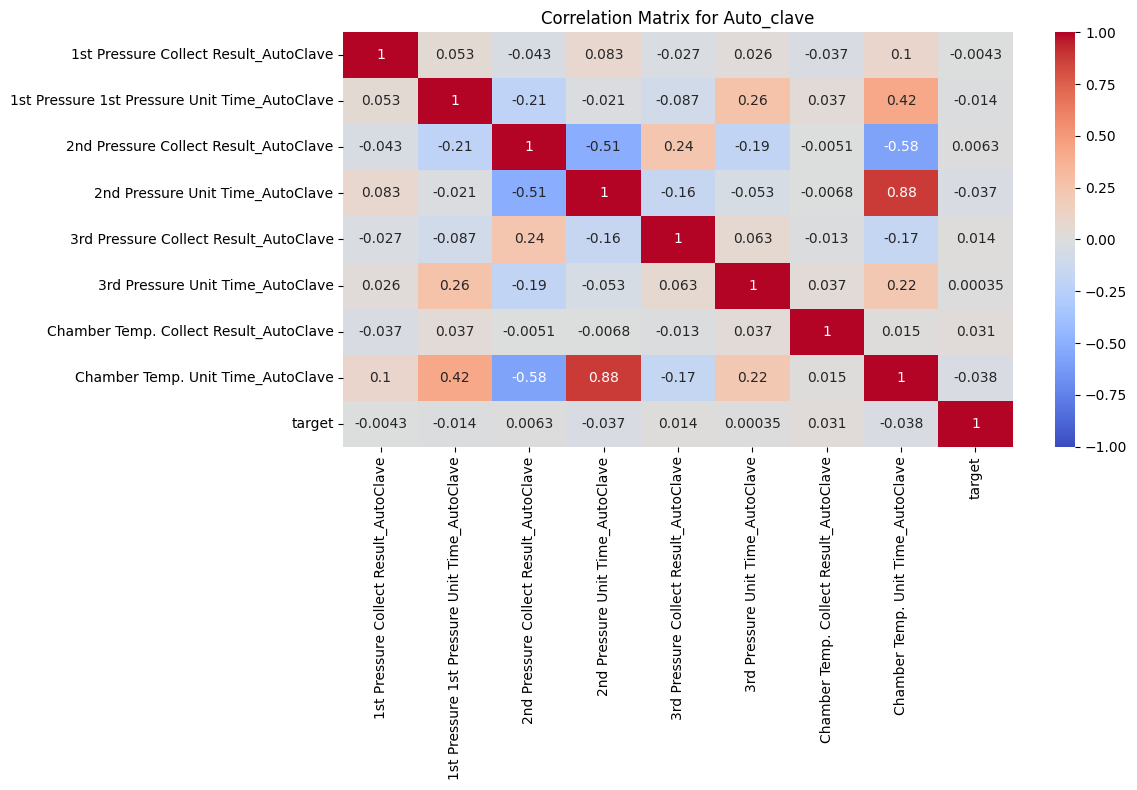

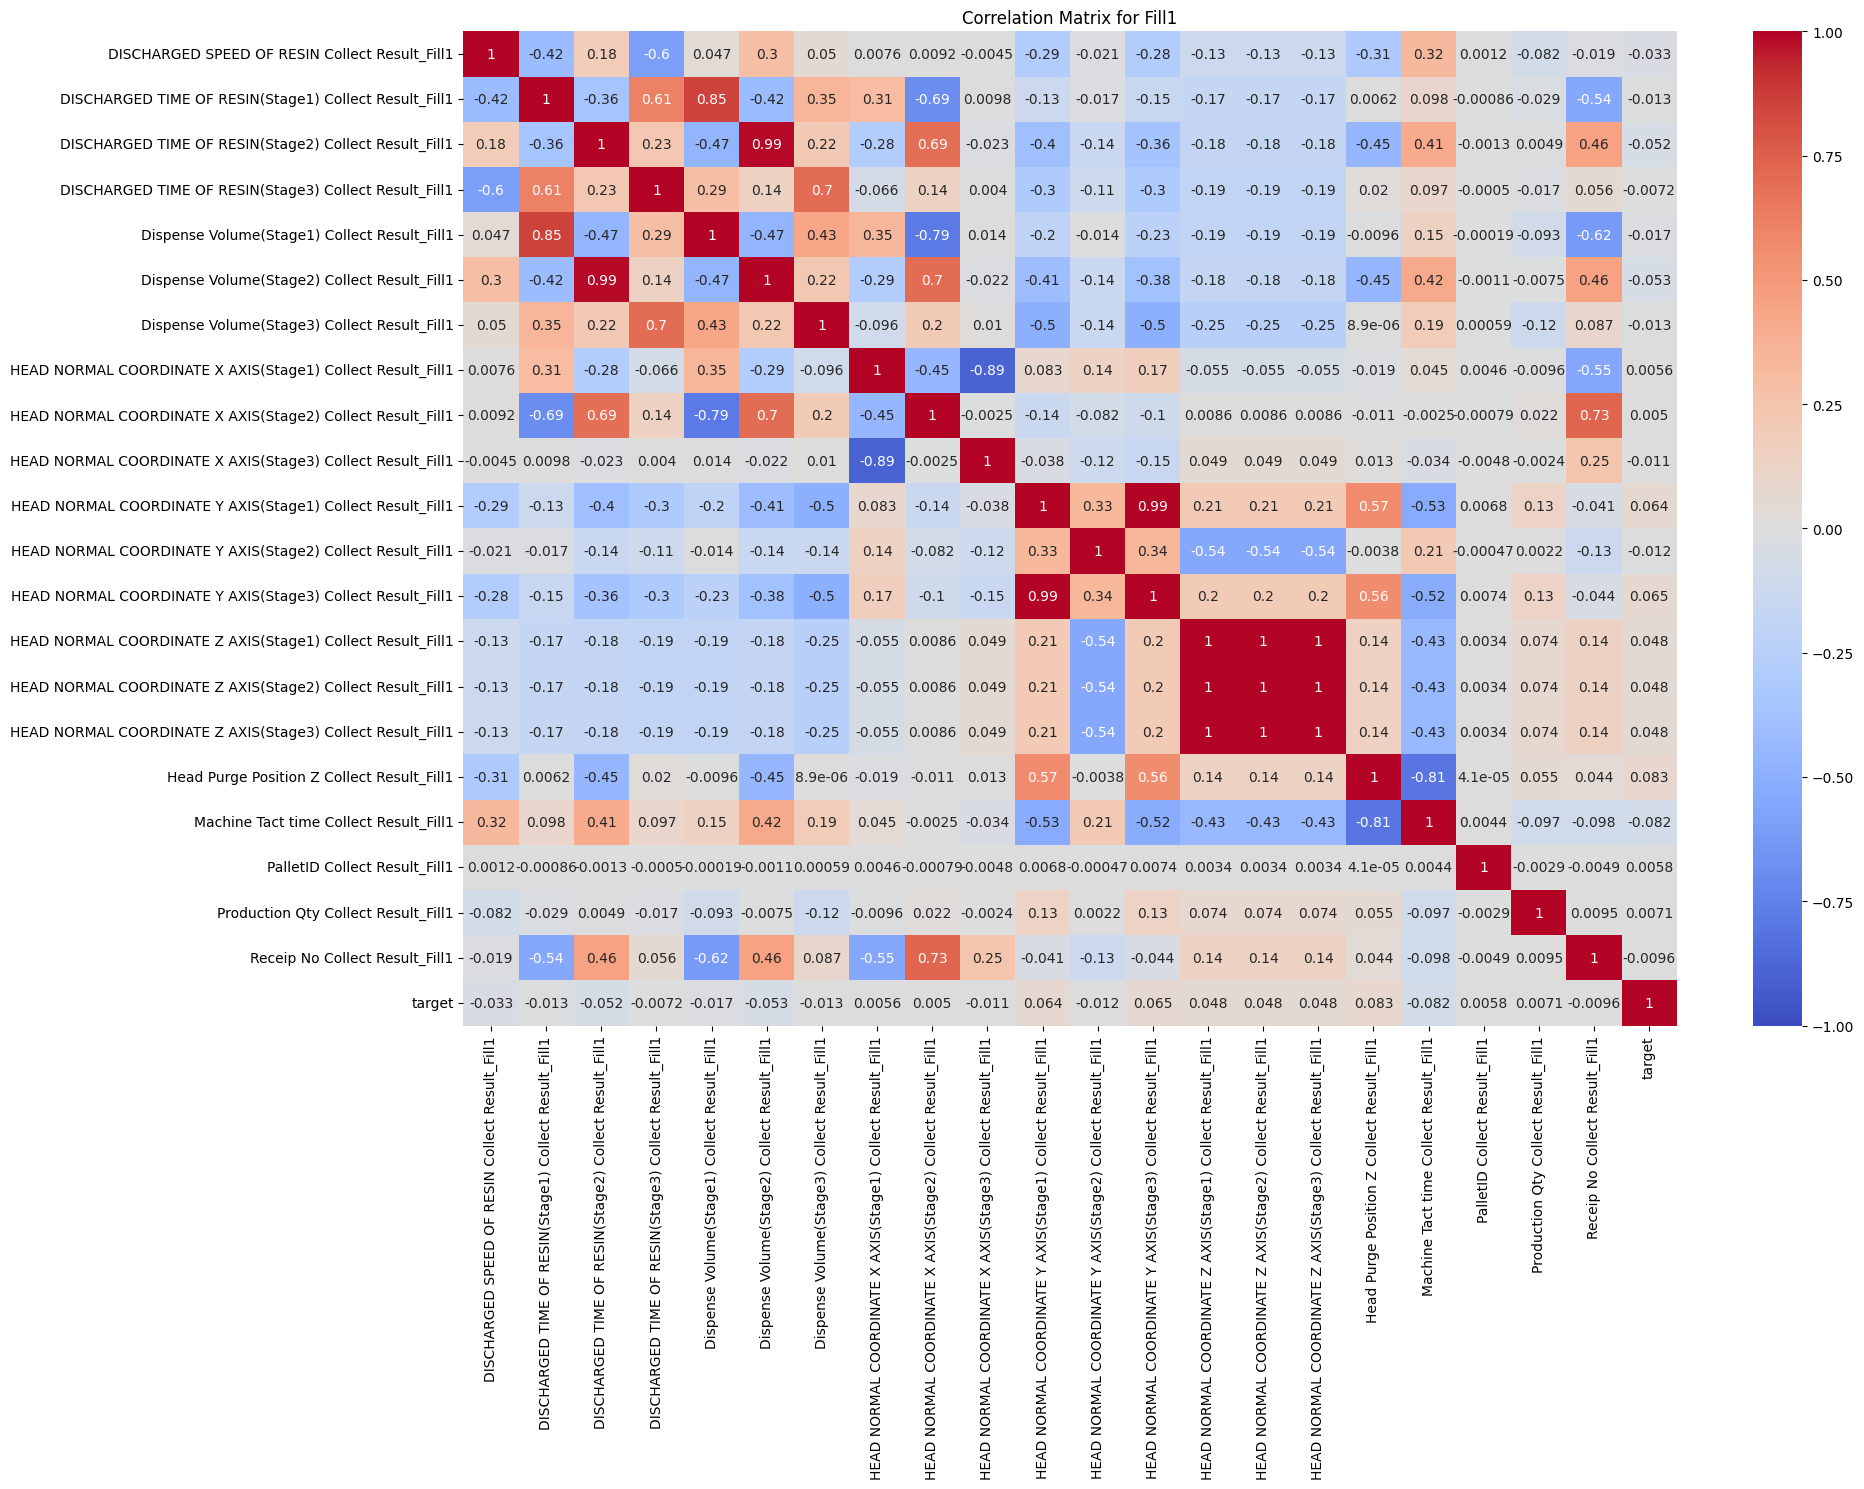

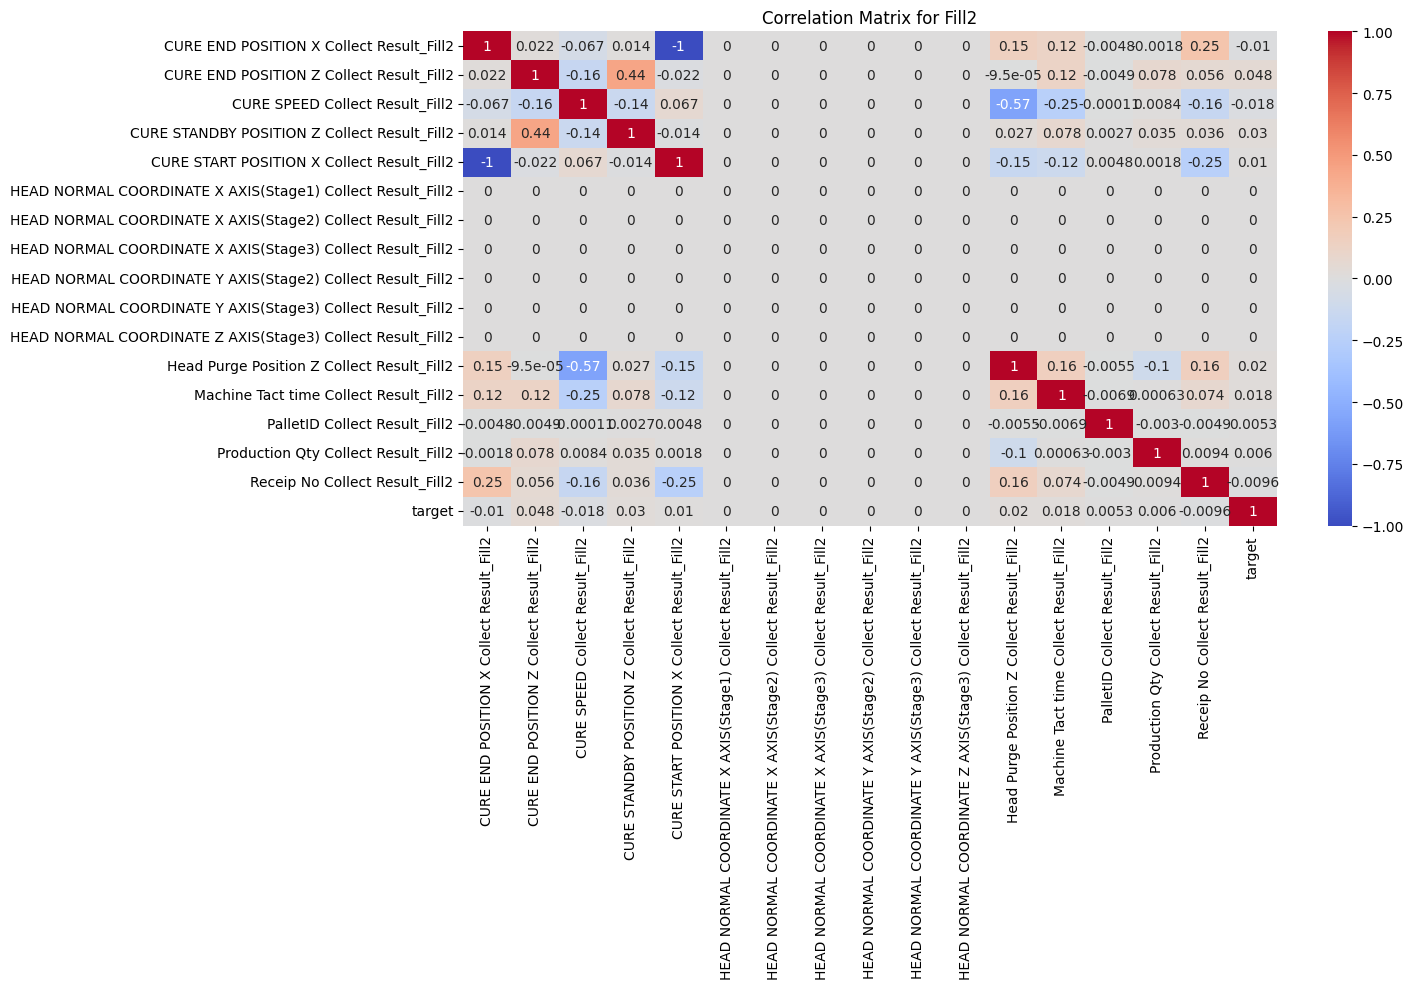

In [241]:
# Normal 데이터만 수집
df_abnormal = df_num[df_num['target']==0]
# 상관 행렬 계산 및 시각화
idx=0
for group_name, columns in groups.items():
    # 그룹에 해당하는 데이터 추출
    columns_with_target = list(columns) + ['target']
    
    # 'target' 열 추가된 데이터프레임 생성
    df_group = df_num[columns_with_target]
    
    # 상관 행렬 계산
    correlation_matrix = df_group.corr()
    correlation_matrix = correlation_matrix.fillna(0)
    # 상관 행렬 시각화
    plt.figure(figsize=figs[idx])
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
    plt.title(f'Correlation Matrix for {group_name}')
    plt.tight_layout()
    plt.savefig(f'./plot/Correlation Matrix for {group_name}_AbNomal.png')
    plt.show()
    idx+=1